# plotting functions of figure 2 in the manuscript
Overview plot of the first section. In the plot we show the result of reconstructing synthetic data simulated with Roodmus into a consensus (homogeneous) density map. 


In [11]:
# imports
import os
import re
import mrcfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# added following for 1to1 match prototyping
from tqdm import tqdm
from typing import Any
from collections.abc import KeysView as dict_keys

from gemmi import cif

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_picking import (
    plot_precision, plot_recall, 
)


In [2]:
# functions
def get_resolution_from_logs(project_dir, data, verbose=False):
    results ={
        "Nparticles": [],
        "res_unmasked": [],
        "res": [],
    }
    
    # load the logfiles and retrieve the resolutions
    for _, item in data.items():
        if verbose:
            print(f"Processing {item['PostProcess']}")
        Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
        pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+(\.\d+)?)"
        with open(Refine3D_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res_unmasked = float(re.search(pattern, line).group(1))
                    break

        PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
        pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
        with open(PostProcess_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res = float(re.search(pattern, line).group(1))
                    break
        
        if verbose:
            print(f"Nparticles: {item['Nparticles']}")
            print(f"res_unmasked: {res_unmasked}")
            print(f"res: {res}")
        results["Nparticles"].append(item["Nparticles"])
        results["res_unmasked"].append(res_unmasked)
        results["res"].append(res)

    return results


## panel A
plot of the 2D classes generated during processing of the homogeneous (single-conformation) data. The 2D classification used here was done after the final reconstruction, for visualisation only and on the full-sized images (320x320).
plot of the FSC curve from RELION.

In [ ]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job042", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job043", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")

In [ ]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
job = "job040"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
resolution = 2.29


fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18, bbox_to_anchor=(0.65, 1.1), loc=2, borderaxespad=0.)

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")


## panel B
ResLog plot for single-conformation data set


In [ ]:
# data for single conformation set
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job037",
        "Refine3D": "job038",
        "MaskCreate": "job039",
        "PostProcess": "job040",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 3000, 4000, 6000, 8000])
ax.set_xticklabels(["1k", "2k", "", "4k", "", "8k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(project_dir, "figures", "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(project_dir, 'figures', 'ResLog.pdf')}")


## panel C
2D classes for the heterogeneous data set
FSC curve for the heterogeneous data set

In [ ]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job058", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job060", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")


In [ ]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
job = "job016"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
figures_dir = os.path.join(project_dir, "figures")
resolution = 3.17

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")

## panel D
ResLog plot for the heterogeneous data set

In [ ]:
# data for full MD trajectory
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job006",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    6: {
        "Nparticles": 16000,
        "Select": "job050",
        "Refine3D": "job051",
        "MaskCreate": "job054",
        "PostProcess": "job055",
    },
    7: {
        "Nparticles": 32000,
        "Select": "job052",
        "Refine3D": "job053",
        "MaskCreate": "job056",
        "PostProcess": "job057",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data, False)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()
ax.legend().remove()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 4000, 8000, 16000, 32000])
ax.set_xticklabels(["1k", "2k", "4k", "8k", "16k", "32k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(figures_dir, "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'ResLog.pdf')}")


## panel E
plot of the resolution dependence on the number of frames of the MD trajectory that are included in the particles. The total number of particles remains constant at 4000

In [ ]:
# define jobs to use
project_dir = "/home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "K": 125,
        "Nparticles": 4000,
        "Import": "job007",
        "Refine3D": "job009",
        "MaskCreate": "job010",
        "PostProcess": "job011",
    },
    1: {
        "K": 8000,
        "Nparticles": 4000,
        "Import": "job012",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    2: {
        "K": 250,
        "Nparticles": 4000,
        "Import": "job017",
        "Refine3D": "job019",
        "MaskCreate": "job020",
        "PostProcess": "job021",
    },
    3: {
        "K": 500,
        "Nparticles": 4000,
        "Import": "job022",
        "Refine3D": "job024",
        "MaskCreate": "job025",
        "PostProcess": "job026",
    },
    4: {
        "K": 1000,
        "Nparticles": 4000,
        "Import": "job027",
        "Refine3D": "job029",
        "MaskCreate": "job030",
        "PostProcess": "job031",
    },
    5: {
        "K": 2000,
        "Nparticles": 4000,
        "Import": "job032",
        "Refine3D": "job034",
        "MaskCreate": "job035",
        "PostProcess": "job036",
    },
    6: {
        "K": 4000,
        "Nparticles": 4000,
        "Import": "job037",
        "Refine3D": "job039",
        "MaskCreate": "job040",
        "PostProcess": "job041",
    },
}

results = {
    "K": [],
    "Nparticles": [],
    "res_unmasked": [],
    "res": [],
    "B_fac": [],
}

# loop over the jobs and get the resolution and B-factor from the log files
for _, item in data.items():
    Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
    pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+\.\d+)"
    with open(Refine3D_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res_unmasked = float(re.search(pattern, line).group(1))
                break

    PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
    pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res = float(re.search(pattern, line).group(1))
                break
    
    pattern = r"\+\s*apply\s+b-factor\s+of:\s+(-?\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                B_fac = float(re.search(pattern, line).group(1))
                break

    results["K"].append(item["K"])
    results["Nparticles"].append(item["Nparticles"])
    results["res_unmasked"].append(res_unmasked)
    results["res"].append(res)
    results["B_fac"].append(-B_fac)
    # results["localres_std"].append(localres_std)

results_df = pd.DataFrame(results)
    
# plot the results
fig, ax_res = plt.subplots(figsize=(3.5, 3.5))
ax_Bfac = ax_res.twinx()
sns.scatterplot(
    data=results_df, x="K", y="res", ax=ax_res, label="resolution", s=100,
)
sns.scatterplot(
    data=results_df, x="K", y="B_fac", ax=ax_Bfac, label="B-factor", color="orange", s=100,
)
ax_res.set_xlabel("first K timepoints", fontsize=21)
ax_res.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax_res.set_xscale("log")
ax_res.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# ax_res.set_ylim((3.0, 4.1))
ax_res.invert_yaxis()
ax_Bfac.set_ylabel("B-factor ($\AA^2$)", fontsize=21, rotation=270, labelpad=30)
# ax_Bfac.set_ylim((40, 65))
# remove legends from the axis and add a single legend
ax_res.get_legend().remove()
ax_Bfac.get_legend().remove()
fig.legend(loc="upper left", bbox_to_anchor=(1.15, 0.40), ncol=1, fontsize=18)

# ax_Bfac.set_yticklabels(ax_Bfac.get_yticklabels(), fontsize=18)
# ax_res.set_yticklabels(ax_res.get_yticklabels(), fontsize=18)
ax_Bfac.tick_params(axis='y', labelsize=18)
ax_res.tick_params(axis='y', labelsize=18)
ax_res.set_xticks([250, 1000, 2000, 4000, 8000])
ax_res.set_xticklabels(["250", "1k", "2k", "4k", "8k"], fontsize=18)

# fig.savefig(os.path.join(figures_dir, "resolution_Bfactor_vs_K.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'resolution_Bfactor_vs_K.pdf')}")


## panel F
plot of the particle picking precision and recall throughout the processing of the heterogeneous data set

In [3]:
# project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
project_dir = "/mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
# project_dir = "/home/dvi41342/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA_subset"
config_dir = os.path.join(project_dir, "Micrographs")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "Extract", "job007", "particles.star"),
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"),
    os.path.join(project_dir, "Select", "job009", "particles.star"),
    # os.path.join(project_dir, "Select", "job036", "particles.star"),
    # os.path.join(project_dir, "Select", "job037", "particles.star"),
    # os.path.join(project_dir, "Select", "job038", "particles.star"),
    # os.path.join(project_dir, "Select", "job039", "particles.star"),
    ## os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"),
    ## os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"),
    ## os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job007", "particles.star"): "topaz picker",
    os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"): "2D classification",
    os.path.join(project_dir, "Select", "job009", "particles.star"): "2D class selection",
    # os.path.join(project_dir, "Select", "job036", "particles.star"): "3D class 0",
    # os.path.join(project_dir, "Select", "job037", "particles.star"): "3D class 1",
    # os.path.join(project_dir, "Select", "job038", "particles.star"): "3D class 2",
    # os.path.join(project_dir, "Select", "job039", "particles.star"): "3D class 3",
    # os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"): "Homogeneous refinement 1",
    # os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"): "Homogeneous refinement 2",
    # os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"): "Homogeneous refinement 3",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
# df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
# print(f"mean precision: {df_precision['precision'].mean()}")
# print(f"mean recall: {df_precision['recall'].mean()}")

p_match, t_match, p_unmatched, t_unmatched = analysis._match_particles(
    meta_files,
    df_picked,
    df_truth,
    verbose=verbose,
)
"""
results_picking = df_picked
results_truth = df_truth
metadata_filename = meta_files[0]
metafile_picked = results_picking.loc[
    results_picking["metadata_filename"] == metadata_filename
]
print("metafile_picked: {}".format(metafile_picked))
print("metafile_picked[ugraph_filename]: {}".format(metafile_picked["ugraph_filename"]))
metafile_truth = results_truth
print("metafile_picked.keys(): {}".format(metafile_picked.keys()))
print("ugraph_ids: {}".format(metafile_picked["ugraph_filename"].unique()))
"""


loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star. determined file type: star


Dictionaries now contain 240974 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star


loading truth data: 100%|██████████| 900/900 [10:06<00:00,  1.48it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 240974 particles and 270000 true particles
Added 270000 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 481948 reconstructed particles
added 240974 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Class2D/job008/run_it200_data.star
loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/D

computing precision: 100%|██████████| 6300/6300 [05:05<00:00, 20.61it/s, precision=1, recall=0.193, multiplicity=0.207]    


time taken to compute precision: 308.2116975784302
mean precision: 0.997717998958324
mean recall: 0.5379248099604771


computing closest matches:   1%|          | 6/900 [00:00<00:55, 16.19it/s]

There are 0 non-unique picked particles in ugraph 000004.mrc!
Shape of 000005.mrc
	sdm: (274, 300)
all nan slice in ugraph 000005.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   1%|          | 10/900 [00:00<00:51, 17.26it/s]

There are 0 non-unique picked particles in ugraph 000007.mrc!
Shape of 000008.mrc
	sdm: (279, 300)
There are 0 non-unique picked particles in ugraph 000008.mrc!
Shape of 000009.mrc
	sdm: (274, 300)
all nan slice in ugraph 000009.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:   2%|▏         | 15/900 [00:00<00:48, 18.26it/s]

Shape of 000011.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000011.mrc!
Shape of 000012.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000012.mrc!
Shape of 000013.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000013.mrc!
Shape of 000014.mrc
	sdm: (274, 300)
all nan slice in ugraph 000014.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   2%|▏         | 19/900 [00:01<00:48, 18.31it/s]

all nan slice in ugraph 000015.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   3%|▎         | 23/900 [00:01<00:48, 18.06it/s]

Shape of 000020.mrc
	sdm: (278, 300)
all nan slice in ugraph 000020.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   3%|▎         | 27/900 [00:01<00:47, 18.21it/s]

Shape of 000024.mrc
	sdm: (264, 300)
all nan slice in ugraph 000024.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   3%|▎         | 31/900 [00:01<00:47, 18.28it/s]

There are 0 non-unique picked particles in ugraph 000028.mrc!
Shape of 000029.mrc
	sdm: (262, 300)
all nan slice in ugraph 000029.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   4%|▍         | 35/900 [00:01<00:46, 18.48it/s]

Shape of 000032.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000032.mrc!
Shape of 000033.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000033.mrc!
Shape of 000034.mrc
	sdm: (267, 300)
all nan slice in ugraph 000034.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   4%|▍         | 40/900 [00:02<00:46, 18.31it/s]

Shape of 000037.mrc
	sdm: (279, 300)
all nan slice in ugraph 000037.mrc with picked particle index 277 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   5%|▍         | 44/900 [00:02<00:47, 18.01it/s]

Shape of 000041.mrc
	sdm: (272, 300)
all nan slice in ugraph 000041.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   5%|▌         | 48/900 [00:02<00:46, 18.26it/s]

Shape of 000045.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000045.mrc!
Shape of 000046.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000046.mrc!
Shape of 000047.mrc
	sdm: (267, 300)
all nan slice in ugraph 000047.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   6%|▌         | 53/900 [00:02<00:44, 18.93it/s]

There are 0 non-unique picked particles in ugraph 000049.mrc!
Shape of 000050.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000050.mrc!
Shape of 000051.mrc
	sdm: (269, 300)
all nan slice in ugraph 000051.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:   6%|▋         | 57/900 [00:03<00:44, 18.74it/s]

There are 0 non-unique picked particles in ugraph 000053.mrc!
Shape of 000054.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000054.mrc!
Shape of 000055.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000055.mrc!
Shape of 000056.mrc
	sdm: (273, 300)
all nan slice in ugraph 000056.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:   7%|▋         | 61/900 [00:03<00:46, 18.17it/s]

Shape of 000057.mrc
	sdm: (268, 300)
all nan slice in ugraph 000057.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   7%|▋         | 65/900 [00:03<00:45, 18.46it/s]

Shape of 000061.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000061.mrc!
Shape of 000062.mrc
	sdm: (275, 300)
all nan slice in ugraph 000062.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   8%|▊         | 69/900 [00:03<00:47, 17.50it/s]

There are 0 non-unique picked particles in ugraph 000065.mrc!
Shape of 000066.mrc
	sdm: (265, 300)
all nan slice in ugraph 000066.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   8%|▊         | 73/900 [00:04<00:46, 17.67it/s]

Shape of 000069.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000069.mrc!
Shape of 000070.mrc
	sdm: (270, 300)
all nan slice in ugraph 000070.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   9%|▊         | 78/900 [00:04<00:44, 18.57it/s]

Shape of 000073.mrc
	sdm: (271, 300)
all nan slice in ugraph 000073.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   9%|▉         | 82/900 [00:04<00:46, 17.43it/s]

Shape of 000078.mrc
	sdm: (270, 300)
all nan slice in ugraph 000078.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|▉         | 86/900 [00:04<00:46, 17.40it/s]

Shape of 000082.mrc
	sdm: (266, 300)
all nan slice in ugraph 000082.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|█         | 90/900 [00:05<00:46, 17.55it/s]

Shape of 000086.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000086.mrc!
Shape of 000087.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000087.mrc!
Shape of 000088.mrc
	sdm: (271, 300)
all nan slice in ugraph 000088.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  10%|█         | 94/900 [00:05<00:45, 17.82it/s]

Shape of 000090.mrc
	sdm: (269, 300)
all nan slice in ugraph 000090.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  11%|█         | 98/900 [00:05<00:44, 18.18it/s]

There are 0 non-unique picked particles in ugraph 000094.mrc!
Shape of 000095.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000095.mrc!
Shape of 000096.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000096.mrc!
Shape of 000097.mrc
	sdm: (270, 300)
all nan slice in ugraph 000097.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  11%|█▏        | 102/900 [00:05<00:43, 18.51it/s]

There are 0 non-unique picked particles in ugraph 000098.mrc!
Shape of 000099.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000099.mrc!
Shape of 000100.mrc
	sdm: (267, 300)
all nan slice in ugraph 000100.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  12%|█▏        | 106/900 [00:05<00:47, 16.89it/s]

Shape of 000102.mrc
	sdm: (267, 300)
all nan slice in ugraph 000102.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  12%|█▏        | 109/900 [00:06<00:43, 18.21it/s]

Shape of 000106.mrc
	sdm: (273, 300)
all nan slice in ugraph 000106.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  13%|█▎        | 114/900 [00:06<00:41, 18.98it/s]

Shape of 000110.mrc
	sdm: (262, 300)
all nan slice in ugraph 000110.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  13%|█▎        | 118/900 [00:06<00:41, 18.75it/s]

There are 0 non-unique picked particles in ugraph 000114.mrc!
Shape of 000115.mrc
	sdm: (270, 300)
all nan slice in ugraph 000115.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  14%|█▎        | 122/900 [00:06<00:41, 18.68it/s]

Shape of 000118.mrc
	sdm: (270, 300)
all nan slice in ugraph 000118.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 126/900 [00:06<00:41, 18.78it/s]

Shape of 000122.mrc
	sdm: (257, 300)
all nan slice in ugraph 000122.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 130/900 [00:07<00:41, 18.65it/s]

There are 0 non-unique picked particles in ugraph 000126.mrc!
Shape of 000127.mrc
	sdm: (270, 300)
all nan slice in ugraph 000127.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  15%|█▍        | 134/900 [00:07<00:40, 18.88it/s]

Shape of 000130.mrc
	sdm: (262, 300)
all nan slice in ugraph 000130.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▌        | 138/900 [00:07<00:40, 18.87it/s]

There are 0 non-unique picked particles in ugraph 000134.mrc!
Shape of 000135.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000135.mrc!
Shape of 000136.mrc
	sdm: (259, 300)
all nan slice in ugraph 000136.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  16%|█▌        | 142/900 [00:07<00:40, 18.52it/s]

There are 0 non-unique picked particles in ugraph 000138.mrc!
Shape of 000139.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000139.mrc!
Shape of 000140.mrc
	sdm: (275, 300)
all nan slice in ugraph 000140.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  16%|█▌        | 146/900 [00:08<00:41, 18.29it/s]

Shape of 000142.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000142.mrc!
Shape of 000143.mrc
	sdm: (273, 300)
all nan slice in ugraph 000143.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  17%|█▋        | 150/900 [00:08<00:40, 18.66it/s]

Shape of 000146.mrc
	sdm: (267, 300)
all nan slice in ugraph 000146.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  17%|█▋        | 154/900 [00:08<00:40, 18.50it/s]

Shape of 000151.mrc
	sdm: (265, 300)
all nan slice in ugraph 000151.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  18%|█▊        | 159/900 [00:08<00:40, 18.41it/s]

There are 0 non-unique picked particles in ugraph 000155.mrc!
Shape of 000156.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000156.mrc!
Shape of 000157.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000157.mrc!
Shape of 000158.mrc
	sdm: (271, 300)
all nan slice in ugraph 000158.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  18%|█▊        | 163/900 [00:08<00:39, 18.84it/s]

Shape of 000159.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000159.mrc!
Shape of 000160.mrc
	sdm: (267, 300)
all nan slice in ugraph 000160.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  19%|█▊        | 167/900 [00:09<00:39, 18.74it/s]

There are 0 non-unique picked particles in ugraph 000163.mrc!
Shape of 000164.mrc
	sdm: (270, 300)
all nan slice in ugraph 000164.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  19%|█▉        | 172/900 [00:09<00:37, 19.31it/s]

Shape of 000168.mrc
	sdm: (269, 300)
all nan slice in ugraph 000168.mrc with picked particle index 245 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  20%|█▉        | 176/900 [00:09<00:39, 18.51it/s]

Shape of 000173.mrc
	sdm: (260, 300)
all nan slice in ugraph 000173.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  20%|██        | 180/900 [00:09<00:38, 18.58it/s]

Shape of 000177.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000177.mrc!
Shape of 000178.mrc
	sdm: (269, 300)
all nan slice in ugraph 000178.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  21%|██        | 185/900 [00:10<00:37, 19.06it/s]

Shape of 000181.mrc
	sdm: (262, 300)
all nan slice in ugraph 000181.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  21%|██        | 187/900 [00:10<00:38, 18.48it/s]

There are 0 non-unique picked particles in ugraph 000185.mrc!
Shape of 000186.mrc
	sdm: (270, 300)
all nan slice in ugraph 000186.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  21%|██▏       | 193/900 [00:10<00:37, 19.02it/s]

There are 0 non-unique picked particles in ugraph 000189.mrc!
Shape of 000190.mrc
	sdm: (269, 300)
all nan slice in ugraph 000190.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  22%|██▏       | 197/900 [00:10<00:36, 19.06it/s]

Shape of 000194.mrc
	sdm: (261, 300)
all nan slice in ugraph 000194.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  22%|██▏       | 201/900 [00:10<00:35, 19.42it/s]

There are 0 non-unique picked particles in ugraph 000198.mrc!
Shape of 000199.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000199.mrc!
Shape of 000200.mrc
	sdm: (271, 300)
all nan slice in ugraph 000200.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  23%|██▎       | 205/900 [00:11<00:36, 19.12it/s]

There are 0 non-unique picked particles in ugraph 000202.mrc!
Shape of 000203.mrc
	sdm: (262, 300)
all nan slice in ugraph 000203.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  23%|██▎       | 209/900 [00:11<00:36, 19.09it/s]

Shape of 000206.mrc
	sdm: (270, 300)
all nan slice in ugraph 000206.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  24%|██▎       | 213/900 [00:11<00:36, 19.04it/s]

There are 0 non-unique picked particles in ugraph 000210.mrc!
Shape of 000211.mrc
	sdm: (268, 300)
all nan slice in ugraph 000211.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  24%|██▍       | 217/900 [00:11<00:36, 18.82it/s]

There are 0 non-unique picked particles in ugraph 000214.mrc!
Shape of 000215.mrc
	sdm: (273, 300)
all nan slice in ugraph 000215.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  25%|██▍       | 222/900 [00:12<00:35, 19.30it/s]

Shape of 000218.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000218.mrc!
Shape of 000219.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000219.mrc!
Shape of 000220.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000220.mrc!
Shape of 000221.mrc
	sdm: (268, 300)
all nan slice in ugraph 000221.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  25%|██▌       | 226/900 [00:12<00:35, 18.93it/s]

There are 0 non-unique picked particles in ugraph 000222.mrc!
Shape of 000223.mrc
	sdm: (265, 300)
all nan slice in ugraph 000223.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  26%|██▌       | 230/900 [00:12<00:36, 18.44it/s]

Shape of 000226.mrc
	sdm: (265, 300)
all nan slice in ugraph 000226.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  26%|██▌       | 234/900 [00:12<00:35, 18.54it/s]

Shape of 000230.mrc
	sdm: (272, 300)
all nan slice in ugraph 000230.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  26%|██▋       | 238/900 [00:12<00:36, 18.24it/s]

all nan slice in ugraph 000234.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  27%|██▋       | 242/900 [00:13<00:35, 18.59it/s]

Shape of 000238.mrc
	sdm: (271, 300)
all nan slice in ugraph 000238.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  27%|██▋       | 246/900 [00:13<00:34, 18.69it/s]

all nan slice in ugraph 000242.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  28%|██▊       | 249/900 [00:13<00:33, 19.42it/s]

There are 0 non-unique picked particles in ugraph 000246.mrc!
Shape of 000247.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000247.mrc!
Shape of 000248.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000248.mrc!
Shape of 000249.mrc
	sdm: (272, 300)
all nan slice in ugraph 000249.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  28%|██▊       | 253/900 [00:13<00:33, 19.16it/s]

There are 0 non-unique picked particles in ugraph 000250.mrc!
Shape of 000251.mrc
	sdm: (273, 300)
all nan slice in ugraph 000251.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  29%|██▊       | 258/900 [00:14<00:33, 19.06it/s]

Shape of 000254.mrc
	sdm: (273, 300)
all nan slice in ugraph 000254.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  29%|██▉       | 263/900 [00:14<00:34, 18.71it/s]

Shape of 000259.mrc
	sdm: (270, 300)
all nan slice in ugraph 000259.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  30%|██▉       | 267/900 [00:14<00:33, 18.69it/s]

Shape of 000263.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000263.mrc!
Shape of 000264.mrc
	sdm: (275, 300)
There are 0 non-unique picked particles in ugraph 000264.mrc!
Shape of 000265.mrc
	sdm: (266, 300)
all nan slice in ugraph 000265.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  30%|███       | 271/900 [00:14<00:33, 18.75it/s]

Shape of 000267.mrc
	sdm: (275, 300)
all nan slice in ugraph 000267.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  31%|███       | 275/900 [00:14<00:33, 18.65it/s]

There are 0 non-unique picked particles in ugraph 000271.mrc!
Shape of 000272.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000272.mrc!
Shape of 000273.mrc
	sdm: (266, 300)
all nan slice in ugraph 000273.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  31%|███       | 280/900 [00:15<00:32, 19.06it/s]

Shape of 000275.mrc
	sdm: (261, 300)
all nan slice in ugraph 000275.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 284/900 [00:15<00:33, 18.50it/s]

Shape of 000280.mrc
	sdm: (267, 300)
all nan slice in ugraph 000280.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 286/900 [00:15<00:32, 18.63it/s]

Shape of 000284.mrc
	sdm: (274, 300)
There are 0 non-unique picked particles in ugraph 000284.mrc!
Shape of 000285.mrc
	sdm: (271, 300)
all nan slice in ugraph 000285.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  33%|███▎      | 293/900 [00:15<00:31, 19.23it/s]

Shape of 000289.mrc
	sdm: (266, 300)
all nan slice in ugraph 000289.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  33%|███▎      | 297/900 [00:16<00:31, 19.11it/s]

There are 0 non-unique picked particles in ugraph 000293.mrc!
Shape of 000294.mrc
	sdm: (269, 300)
all nan slice in ugraph 000294.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  33%|███▎      | 300/900 [00:16<00:31, 19.29it/s]

Shape of 000297.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000297.mrc!
Shape of 000298.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000298.mrc!
Shape of 000299.mrc
	sdm: (268, 300)
all nan slice in ugraph 000299.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  34%|███▍      | 304/900 [00:16<00:31, 19.16it/s]

There are 0 non-unique picked particles in ugraph 000301.mrc!
Shape of 000302.mrc
	sdm: (275, 300)
all nan slice in ugraph 000302.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  34%|███▍      | 308/900 [00:16<00:31, 18.53it/s]

There are 0 non-unique picked particles in ugraph 000305.mrc!
Shape of 000306.mrc
	sdm: (268, 300)
all nan slice in ugraph 000306.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  35%|███▍      | 313/900 [00:16<00:30, 19.02it/s]

Shape of 000309.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000309.mrc!
Shape of 000310.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000310.mrc!
Shape of 000311.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000311.mrc!
Shape of 000312.mrc
	sdm: (272, 300)
all nan slice in ugraph 000312.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  35%|███▌      | 317/900 [00:17<00:31, 18.38it/s]

There are 0 non-unique picked particles in ugraph 000313.mrc!
Shape of 000314.mrc
	sdm: (264, 300)
all nan slice in ugraph 000314.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  36%|███▌      | 321/900 [00:17<00:31, 18.16it/s]

Shape of 000317.mrc
	sdm: (267, 300)
all nan slice in ugraph 000317.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▌      | 325/900 [00:17<00:31, 18.19it/s]

Shape of 000321.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000321.mrc!
Shape of 000322.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000322.mrc!
Shape of 000323.mrc
	sdm: (261, 300)
all nan slice in ugraph 000323.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  37%|███▋      | 329/900 [00:17<00:31, 17.92it/s]

Shape of 000325.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000325.mrc!
Shape of 000326.mrc
	sdm: (271, 300)
all nan slice in ugraph 000326.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  37%|███▋      | 333/900 [00:18<00:30, 18.73it/s]

Shape of 000329.mrc
	sdm: (273, 300)
all nan slice in ugraph 000329.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  37%|███▋      | 335/900 [00:18<00:30, 18.55it/s]

There are 0 non-unique picked particles in ugraph 000333.mrc!
Shape of 000334.mrc
	sdm: (269, 300)
all nan slice in ugraph 000334.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  38%|███▊      | 340/900 [00:18<00:29, 19.19it/s]

There are 0 non-unique picked particles in ugraph 000337.mrc!
Shape of 000338.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000338.mrc!
Shape of 000339.mrc
	sdm: (274, 300)
all nan slice in ugraph 000339.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  38%|███▊      | 344/900 [00:18<00:30, 18.35it/s]

There are 0 non-unique picked particles in ugraph 000341.mrc!
Shape of 000342.mrc
	sdm: (267, 300)
all nan slice in ugraph 000342.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  39%|███▊      | 348/900 [00:18<00:29, 18.90it/s]

Shape of 000345.mrc
	sdm: (274, 300)
all nan slice in ugraph 000345.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  39%|███▉      | 353/900 [00:19<00:27, 19.64it/s]

There are 0 non-unique picked particles in ugraph 000349.mrc!
Shape of 000350.mrc
	sdm: (267, 300)
all nan slice in ugraph 000350.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  40%|███▉      | 358/900 [00:19<00:27, 19.64it/s]

There are 0 non-unique picked particles in ugraph 000353.mrc!
Shape of 000354.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000354.mrc!
Shape of 000355.mrc
	sdm: (280, 300)
There are 0 non-unique picked particles in ugraph 000355.mrc!
Shape of 000356.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000356.mrc!
Shape of 000357.mrc
	sdm: (263, 300)
all nan slice in ugraph 000357.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

computing closest matches:  40%|████      | 362/900 [00:19<00:28, 18.67it/s]

Shape of 000358.mrc
	sdm: (265, 300)
all nan slice in ugraph 000358.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  41%|████      | 366/900 [00:19<00:29, 17.95it/s]

Shape of 000362.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000362.mrc!
Shape of 000363.mrc
	sdm: (262, 300)
all nan slice in ugraph 000363.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  41%|████      | 370/900 [00:19<00:29, 17.95it/s]

Shape of 000366.mrc
	sdm: (281, 300)
all nan slice in ugraph 000366.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  42%|████▏     | 374/900 [00:20<00:28, 18.65it/s]

Shape of 000370.mrc
	sdm: (264, 300)
all nan slice in ugraph 000370.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  42%|████▏     | 378/900 [00:20<00:28, 18.17it/s]

Shape of 000374.mrc
	sdm: (275, 300)
all nan slice in ugraph 000374.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  42%|████▏     | 382/900 [00:20<00:28, 18.09it/s]

Shape of 000378.mrc
	sdm: (265, 300)
all nan slice in ugraph 000378.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 386/900 [00:20<00:28, 18.23it/s]

Shape of 000382.mrc
	sdm: (270, 300)
all nan slice in ugraph 000382.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 391/900 [00:21<00:26, 19.56it/s]

There are 0 non-unique picked particles in ugraph 000386.mrc!
Shape of 000387.mrc
	sdm: (275, 300)
all nan slice in ugraph 000387.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  44%|████▍     | 395/900 [00:21<00:26, 19.40it/s]

Shape of 000391.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000391.mrc!
Shape of 000392.mrc
	sdm: (273, 300)
all nan slice in ugraph 000392.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  44%|████▍     | 399/900 [00:21<00:25, 19.36it/s]

There are 0 non-unique picked particles in ugraph 000395.mrc!
Shape of 000396.mrc
	sdm: (267, 300)
all nan slice in ugraph 000396.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  45%|████▍     | 402/900 [00:21<00:25, 19.90it/s]

all nan slice in ugraph 000399.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  45%|████▌     | 406/900 [00:21<00:25, 19.14it/s]

There are 0 non-unique picked particles in ugraph 000403.mrc!
Shape of 000404.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000404.mrc!
Shape of 000405.mrc
	sdm: (264, 300)
all nan slice in ugraph 000405.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  46%|████▌     | 410/900 [00:22<00:26, 18.54it/s]

There are 0 non-unique picked particles in ugraph 000407.mrc!
Shape of 000408.mrc
	sdm: (272, 300)
all nan slice in ugraph 000408.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  46%|████▌     | 414/900 [00:22<00:26, 18.21it/s]

Shape of 000411.mrc
	sdm: (269, 300)
all nan slice in ugraph 000411.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  46%|████▋     | 418/900 [00:22<00:26, 18.22it/s]

There are 0 non-unique picked particles in ugraph 000415.mrc!
Shape of 000416.mrc
	sdm: (273, 300)
all nan slice in ugraph 000416.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  47%|████▋     | 422/900 [00:22<00:26, 17.95it/s]

Shape of 000419.mrc
	sdm: (269, 300)
all nan slice in ugraph 000419.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  47%|████▋     | 427/900 [00:23<00:26, 18.09it/s]

Shape of 000424.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000424.mrc!
Shape of 000425.mrc
	sdm: (273, 300)
all nan slice in ugraph 000425.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  48%|████▊     | 431/900 [00:23<00:26, 18.04it/s]

Shape of 000428.mrc
	sdm: (261, 300)
all nan slice in ugraph 000428.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  48%|████▊     | 435/900 [00:23<00:26, 17.32it/s]

Shape of 000432.mrc
	sdm: (272, 300)
all nan slice in ugraph 000432.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  49%|████▉     | 439/900 [00:23<00:25, 17.91it/s]

Shape of 000436.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000436.mrc!
Shape of 000437.mrc
	sdm: (275, 300)
all nan slice in ugraph 000437.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  49%|████▉     | 443/900 [00:23<00:25, 18.27it/s]

There are 0 non-unique picked particles in ugraph 000440.mrc!
Shape of 000441.mrc
	sdm: (275, 300)
all nan slice in ugraph 000441.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  50%|████▉     | 448/900 [00:24<00:23, 19.19it/s]

There are 0 non-unique picked particles in ugraph 000444.mrc!
Shape of 000445.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000445.mrc!
Shape of 000446.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000446.mrc!
Shape of 000447.mrc
	sdm: (271, 300)
all nan slice in ugraph 000447.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  50%|█████     | 452/900 [00:24<00:24, 18.03it/s]

There are 0 non-unique picked particles in ugraph 000448.mrc!
Shape of 000449.mrc
	sdm: (271, 300)
all nan slice in ugraph 000449.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  51%|█████     | 457/900 [00:24<00:23, 18.69it/s]

Shape of 000452.mrc
	sdm: (265, 300)
all nan slice in ugraph 000452.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  51%|█████     | 459/900 [00:24<00:23, 18.51it/s]

Shape of 000457.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000457.mrc!
Shape of 000458.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000458.mrc!
Shape of 000459.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000459.mrc!
Shape of 000460.mrc
	sdm: (245, 300)
There are 0 non-unique picked particles in ugraph 000460.mrc!
Shape of 000461.mrc
	sdm: (265, 300)
all nan slice in ugraph 000461.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  52%|█████▏    | 464/900 [00:25<00:23, 18.77it/s]

There are 0 non-unique picked particles in ugraph 000461.mrc!
Shape of 000462.mrc
	sdm: (272, 300)
all nan slice in ugraph 000462.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  52%|█████▏    | 468/900 [00:25<00:23, 18.60it/s]

There are 0 non-unique picked particles in ugraph 000465.mrc!
Shape of 000466.mrc
	sdm: (258, 300)
all nan slice in ugraph 000466.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  52%|█████▏    | 472/900 [00:25<00:23, 18.51it/s]

Shape of 000469.mrc
	sdm: (272, 300)
all nan slice in ugraph 000469.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  53%|█████▎    | 476/900 [00:25<00:23, 18.34it/s]

There are 0 non-unique picked particles in ugraph 000473.mrc!
Shape of 000474.mrc
	sdm: (270, 300)
all nan slice in ugraph 000474.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  53%|█████▎    | 480/900 [00:25<00:23, 17.90it/s]

Shape of 000477.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000477.mrc!
Shape of 000478.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000478.mrc!
Shape of 000479.mrc
	sdm: (263, 300)
all nan slice in ugraph 000479.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  54%|█████▍    | 484/900 [00:26<00:22, 18.11it/s]

Shape of 000481.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000481.mrc!
Shape of 000482.mrc
	sdm: (274, 300)
all nan slice in ugraph 000482.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  54%|█████▍    | 488/900 [00:26<00:22, 18.42it/s]

Shape of 000485.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000485.mrc!
Shape of 000486.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000486.mrc!
Shape of 000487.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000487.mrc!
Shape of 000488.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000488.mrc!
Shape of 000489.mrc
	sdm: (278, 300)
all nan slice in ugraph 000489.mrc with picked particle index 240 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  55%|█████▍    | 492/900 [00:26<00:22, 18.31it/s]

all nan slice in ugraph 000489.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  55%|█████▌    | 496/900 [00:26<00:21, 19.02it/s]

There are 0 non-unique picked particles in ugraph 000493.mrc!
Shape of 000494.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000494.mrc!
Shape of 000495.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000495.mrc!
Shape of 000496.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000496.mrc!
Shape of 000497.mrc
	sdm: (264, 300)
all nan slice in ugraph 000497.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

computing closest matches:  56%|█████▌    | 500/900 [00:27<00:20, 19.07it/s]

There are 0 non-unique picked particles in ugraph 000497.mrc!
Shape of 000498.mrc
	sdm: (262, 300)
all nan slice in ugraph 000498.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  56%|█████▌    | 504/900 [00:27<00:21, 18.48it/s]

all nan slice in ugraph 000501.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  56%|█████▋    | 508/900 [00:27<00:21, 17.82it/s]

Shape of 000505.mrc
	sdm: (274, 300)
all nan slice in ugraph 000505.mrc with picked particle index 245 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  57%|█████▋    | 512/900 [00:27<00:21, 18.10it/s]

Shape of 000509.mrc
	sdm: (264, 300)
all nan slice in ugraph 000509.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  57%|█████▋    | 516/900 [00:27<00:21, 17.98it/s]

There are 0 non-unique picked particles in ugraph 000513.mrc!
Shape of 000514.mrc
	sdm: (271, 300)
all nan slice in ugraph 000514.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  58%|█████▊    | 520/900 [00:28<00:20, 18.12it/s]

There are 0 non-unique picked particles in ugraph 000517.mrc!
Shape of 000518.mrc
	sdm: (265, 300)
all nan slice in ugraph 000518.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  58%|█████▊    | 524/900 [00:28<00:20, 18.06it/s]

Shape of 000521.mrc
	sdm: (260, 300)
all nan slice in ugraph 000521.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  59%|█████▊    | 528/900 [00:28<00:20, 18.38it/s]

Shape of 000525.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000525.mrc!
Shape of 000526.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000526.mrc!
Shape of 000527.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000527.mrc!
Shape of 000528.mrc
	sdm: (270, 300)
all nan slice in ugraph 000528.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  59%|█████▉    | 532/900 [00:28<00:20, 17.81it/s]

all nan slice in ugraph 000529.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  60%|█████▉    | 536/900 [00:29<00:20, 17.54it/s]

Shape of 000533.mrc
	sdm: (265, 300)
all nan slice in ugraph 000533.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|██████    | 541/900 [00:29<00:20, 17.94it/s]

There are 0 non-unique picked particles in ugraph 000537.mrc!
Shape of 000538.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000538.mrc!
Shape of 000539.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000539.mrc!
Shape of 000540.mrc
	sdm: (264, 300)
all nan slice in ugraph 000540.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  61%|██████    | 545/900 [00:29<00:19, 17.96it/s]

Shape of 000541.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000541.mrc!
Shape of 000542.mrc
	sdm: (273, 300)
all nan slice in ugraph 000542.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  61%|██████    | 549/900 [00:29<00:18, 18.55it/s]

Shape of 000545.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000545.mrc!
Shape of 000546.mrc
	sdm: (269, 300)
all nan slice in ugraph 000546.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  61%|██████▏   | 553/900 [00:29<00:18, 18.56it/s]

There are 0 non-unique picked particles in ugraph 000549.mrc!
Shape of 000550.mrc
	sdm: (265, 300)
all nan slice in ugraph 000550.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  62%|██████▏   | 557/900 [00:30<00:18, 18.86it/s]

Shape of 000554.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000554.mrc!
Shape of 000555.mrc
	sdm: (272, 300)
all nan slice in ugraph 000555.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  62%|██████▏   | 561/900 [00:30<00:18, 18.72it/s]

Shape of 000558.mrc
	sdm: (265, 300)
all nan slice in ugraph 000558.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  63%|██████▎   | 565/900 [00:30<00:17, 18.79it/s]

There are 0 non-unique picked particles in ugraph 000562.mrc!
Shape of 000563.mrc
	sdm: (268, 300)
all nan slice in ugraph 000563.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  63%|██████▎   | 569/900 [00:30<00:18, 18.31it/s]

Shape of 000566.mrc
	sdm: (273, 300)
all nan slice in ugraph 000566.mrc with picked particle index 231 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  64%|██████▎   | 573/900 [00:31<00:17, 18.61it/s]

Shape of 000570.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000570.mrc!
Shape of 000571.mrc
	sdm: (267, 300)
all nan slice in ugraph 000571.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  64%|██████▍   | 577/900 [00:31<00:17, 18.42it/s]

Shape of 000574.mrc
	sdm: (271, 300)
all nan slice in ugraph 000574.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  65%|██████▍   | 581/900 [00:31<00:17, 18.72it/s]

all nan slice in ugraph 000578.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  65%|██████▌   | 586/900 [00:31<00:16, 18.98it/s]

There are 0 non-unique picked particles in ugraph 000582.mrc!
Shape of 000583.mrc
	sdm: (261, 300)
all nan slice in ugraph 000583.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  66%|██████▌   | 591/900 [00:32<00:15, 19.47it/s]

Shape of 000587.mrc
	sdm: (264, 300)
all nan slice in ugraph 000587.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  66%|██████▌   | 595/900 [00:32<00:16, 18.96it/s]

Shape of 000592.mrc
	sdm: (264, 300)
all nan slice in ugraph 000592.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  67%|██████▋   | 600/900 [00:32<00:15, 18.85it/s]

Shape of 000596.mrc
	sdm: (273, 300)
all nan slice in ugraph 000596.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  67%|██████▋   | 604/900 [00:32<00:16, 18.40it/s]

Shape of 000601.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000601.mrc!
Shape of 000602.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000602.mrc!
Shape of 000603.mrc
	sdm: (270, 300)
all nan slice in ugraph 000603.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  68%|██████▊   | 608/900 [00:32<00:15, 18.49it/s]

Shape of 000605.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000605.mrc!
Shape of 000606.mrc
	sdm: (267, 300)
all nan slice in ugraph 000606.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  68%|██████▊   | 613/900 [00:33<00:15, 18.46it/s]

Shape of 000609.mrc
	sdm: (275, 300)
all nan slice in ugraph 000609.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  69%|██████▊   | 617/900 [00:33<00:15, 18.06it/s]

There are 0 non-unique picked particles in ugraph 000613.mrc!
Shape of 000614.mrc
	sdm: (270, 300)
all nan slice in ugraph 000614.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  69%|██████▉   | 621/900 [00:33<00:15, 18.47it/s]

Shape of 000617.mrc
	sdm: (270, 300)
all nan slice in ugraph 000617.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  69%|██████▉   | 625/900 [00:33<00:15, 17.90it/s]

There are 0 non-unique picked particles in ugraph 000621.mrc!
Shape of 000622.mrc
	sdm: (266, 300)
all nan slice in ugraph 000622.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  70%|██████▉   | 629/900 [00:34<00:15, 17.60it/s]

Shape of 000625.mrc
	sdm: (271, 300)
all nan slice in ugraph 000625.mrc with picked particle index 224 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|███████   | 633/900 [00:34<00:15, 17.57it/s]

Shape of 000629.mrc
	sdm: (263, 300)
all nan slice in ugraph 000629.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  71%|███████   | 637/900 [00:34<00:14, 18.09it/s]

Shape of 000633.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000633.mrc!
Shape of 000634.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000634.mrc!
Shape of 000635.mrc
	sdm: (271, 300)
all nan slice in ugraph 000635.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  71%|███████   | 641/900 [00:34<00:14, 17.85it/s]

There are 0 non-unique picked particles in ugraph 000637.mrc!
Shape of 000638.mrc
	sdm: (261, 300)
all nan slice in ugraph 000638.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  71%|███████▏  | 643/900 [00:34<00:14, 17.54it/s]

Shape of 000641.mrc
	sdm: (259, 300)
all nan slice in ugraph 000641.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  72%|███████▏  | 648/900 [00:35<00:13, 18.67it/s]

There are 0 non-unique picked particles in ugraph 000645.mrc!
Shape of 000646.mrc
	sdm: (268, 300)
all nan slice in ugraph 000646.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  72%|███████▏  | 652/900 [00:35<00:13, 18.49it/s]

There are 0 non-unique picked particles in ugraph 000649.mrc!
Shape of 000650.mrc
	sdm: (272, 300)
all nan slice in ugraph 000650.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  73%|███████▎  | 656/900 [00:35<00:13, 17.98it/s]

Shape of 000653.mrc
	sdm: (265, 300)
all nan slice in ugraph 000653.mrc with picked particle index 243 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  73%|███████▎  | 660/900 [00:35<00:13, 17.76it/s]

Shape of 000657.mrc
	sdm: (271, 300)
all nan slice in ugraph 000657.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  74%|███████▍  | 664/900 [00:36<00:13, 18.01it/s]

Shape of 000661.mrc
	sdm: (275, 300)
all nan slice in ugraph 000661.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  74%|███████▍  | 669/900 [00:36<00:12, 18.66it/s]

Shape of 000665.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000665.mrc!
Shape of 000666.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000666.mrc!
Shape of 000667.mrc
	sdm: (261, 300)
all nan slice in ugraph 000667.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  75%|███████▍  | 674/900 [00:36<00:11, 19.21it/s]

all nan slice in ugraph 000669.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  75%|███████▌  | 677/900 [00:36<00:11, 19.80it/s]

Shape of 000674.mrc
	sdm: (269, 300)
all nan slice in ugraph 000674.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  76%|███████▌  | 681/900 [00:36<00:11, 19.34it/s]

There are 0 non-unique picked particles in ugraph 000678.mrc!
Shape of 000679.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000679.mrc!
Shape of 000680.mrc
	sdm: (267, 300)
all nan slice in ugraph 000680.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  76%|███████▌  | 686/900 [00:37<00:10, 19.48it/s]

Shape of 000683.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000683.mrc!
Shape of 000684.mrc
	sdm: (268, 300)
all nan slice in ugraph 000684.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  77%|███████▋  | 690/900 [00:37<00:11, 18.82it/s]

There are 0 non-unique picked particles in ugraph 000687.mrc!
Shape of 000688.mrc
	sdm: (264, 300)
all nan slice in ugraph 000688.mrc with picked particle index 235 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  77%|███████▋  | 694/900 [00:37<00:10, 18.78it/s]

Shape of 000691.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000691.mrc!
Shape of 000692.mrc
	sdm: (270, 300)
all nan slice in ugraph 000692.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  78%|███████▊  | 700/900 [00:37<00:10, 18.74it/s]

Shape of 000696.mrc
	sdm: (275, 300)
all nan slice in ugraph 000696.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  78%|███████▊  | 704/900 [00:38<00:10, 18.80it/s]

Shape of 000700.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000700.mrc!
Shape of 000701.mrc
	sdm: (266, 300)
all nan slice in ugraph 000701.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  79%|███████▊  | 708/900 [00:38<00:10, 18.34it/s]

There are 0 non-unique picked particles in ugraph 000704.mrc!
Shape of 000705.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000705.mrc!
Shape of 000706.mrc
	sdm: (271, 300)
all nan slice in ugraph 000706.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  79%|███████▉  | 710/900 [00:38<00:10, 18.02it/s]

Shape of 000708.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000708.mrc!
Shape of 000709.mrc
	sdm: (263, 300)
all nan slice in ugraph 000709.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  79%|███████▉  | 715/900 [00:38<00:10, 18.40it/s]

There are 0 non-unique picked particles in ugraph 000712.mrc!
Shape of 000713.mrc
	sdm: (270, 300)
all nan slice in ugraph 000713.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  80%|███████▉  | 719/900 [00:38<00:10, 17.39it/s]

Shape of 000716.mrc
	sdm: (276, 300)
There are 0 non-unique picked particles in ugraph 000716.mrc!
Shape of 000717.mrc
	sdm: (268, 300)
all nan slice in ugraph 000717.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  80%|████████  | 723/900 [00:39<00:10, 17.13it/s]

Shape of 000720.mrc
	sdm: (278, 300)
all nan slice in ugraph 000720.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  81%|████████  | 727/900 [00:39<00:10, 16.80it/s]

Shape of 000724.mrc
	sdm: (264, 300)
all nan slice in ugraph 000724.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  81%|████████▏ | 732/900 [00:39<00:08, 18.71it/s]

Shape of 000728.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000728.mrc!
Shape of 000729.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000729.mrc!
Shape of 000730.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000730.mrc!
Shape of 000731.mrc
	sdm: (272, 300)
all nan slice in ugraph 000731.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  82%|████████▏ | 737/900 [00:39<00:08, 19.49it/s]

Shape of 000733.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000733.mrc!
Shape of 000734.mrc
	sdm: (266, 300)
all nan slice in ugraph 000734.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  82%|████████▏ | 741/900 [00:40<00:08, 18.91it/s]

There are 0 non-unique picked particles in ugraph 000737.mrc!
Shape of 000738.mrc
	sdm: (270, 300)
all nan slice in ugraph 000738.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  83%|████████▎ | 744/900 [00:40<00:08, 18.97it/s]

Shape of 000741.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000741.mrc!
Shape of 000742.mrc
	sdm: (269, 300)
all nan slice in ugraph 000742.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  83%|████████▎ | 748/900 [00:40<00:08, 18.99it/s]

Shape of 000745.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000745.mrc!
Shape of 000746.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000746.mrc!
Shape of 000747.mrc
	sdm: (272, 300)
all nan slice in ugraph 000747.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  84%|████████▎ | 752/900 [00:40<00:08, 18.45it/s]

There are 0 non-unique picked particles in ugraph 000749.mrc!
Shape of 000750.mrc
	sdm: (270, 300)
all nan slice in ugraph 000750.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  84%|████████▍ | 756/900 [00:40<00:07, 18.64it/s]

Shape of 000753.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000753.mrc!
Shape of 000754.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000754.mrc!
Shape of 000755.mrc
	sdm: (266, 300)
all nan slice in ugraph 000755.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  84%|████████▍ | 760/900 [00:41<00:07, 18.86it/s]

There are 0 non-unique picked particles in ugraph 000757.mrc!
Shape of 000758.mrc
	sdm: (273, 300)
all nan slice in ugraph 000758.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  85%|████████▍ | 764/900 [00:41<00:07, 18.12it/s]

all nan slice in ugraph 000761.mrc with picked particle index 280 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  85%|████████▌ | 768/900 [00:41<00:07, 17.38it/s]

Shape of 000765.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000765.mrc!
Shape of 000766.mrc
	sdm: (265, 300)
all nan slice in ugraph 000766.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  86%|████████▌ | 772/900 [00:41<00:07, 17.68it/s]

Shape of 000769.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000769.mrc!
Shape of 000770.mrc
	sdm: (275, 300)
all nan slice in ugraph 000770.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  86%|████████▌ | 776/900 [00:42<00:07, 16.86it/s]

Shape of 000773.mrc
	sdm: (268, 300)
all nan slice in ugraph 000773.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 780/900 [00:42<00:07, 16.87it/s]

Shape of 000777.mrc
	sdm: (269, 300)
all nan slice in ugraph 000777.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 785/900 [00:42<00:06, 17.99it/s]

Shape of 000781.mrc
	sdm: (273, 300)
all nan slice in ugraph 000781.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  88%|████████▊ | 789/900 [00:42<00:06, 17.83it/s]

Shape of 000786.mrc
	sdm: (268, 300)
all nan slice in ugraph 000786.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  88%|████████▊ | 793/900 [00:43<00:06, 17.62it/s]

Shape of 000790.mrc
	sdm: (267, 300)
all nan slice in ugraph 000790.mrc with picked particle index 188 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▊ | 797/900 [00:43<00:06, 16.16it/s]

Shape of 000794.mrc
	sdm: (273, 300)
all nan slice in ugraph 000794.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▉ | 802/900 [00:43<00:05, 17.96it/s]

There are 0 non-unique picked particles in ugraph 000797.mrc!
Shape of 000798.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000798.mrc!
Shape of 000799.mrc
	sdm: (278, 300)
all nan slice in ugraph 000799.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  90%|████████▉ | 806/900 [00:43<00:05, 18.47it/s]

Shape of 000802.mrc
	sdm: (262, 300)
all nan slice in ugraph 000802.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  90%|█████████ | 811/900 [00:44<00:04, 19.23it/s]

Shape of 000807.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000807.mrc!
Shape of 000808.mrc
	sdm: (267, 300)
all nan slice in ugraph 000808.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  91%|█████████ | 815/900 [00:44<00:04, 18.50it/s]

all nan slice in ugraph 000811.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  91%|█████████ | 817/900 [00:44<00:04, 18.50it/s]

Shape of 000815.mrc
	sdm: (271, 300)
all nan slice in ugraph 000815.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  91%|█████████▏| 822/900 [00:44<00:04, 18.25it/s]

There are 0 non-unique picked particles in ugraph 000819.mrc!
Shape of 000820.mrc
	sdm: (272, 300)
all nan slice in ugraph 000820.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  92%|█████████▏| 826/900 [00:44<00:04, 18.32it/s]

Shape of 000823.mrc
	sdm: (270, 300)
all nan slice in ugraph 000823.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  92%|█████████▏| 830/900 [00:45<00:04, 17.25it/s]

Shape of 000827.mrc
	sdm: (266, 300)
all nan slice in ugraph 000827.mrc with picked particle index 237 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 834/900 [00:45<00:03, 17.84it/s]

Shape of 000831.mrc
	sdm: (275, 300)
all nan slice in ugraph 000831.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 840/900 [00:45<00:03, 19.18it/s]

There are 0 non-unique picked particles in ugraph 000835.mrc!
Shape of 000836.mrc
	sdm: (271, 300)
all nan slice in ugraph 000836.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  94%|█████████▎| 843/900 [00:45<00:02, 19.90it/s]

Shape of 000840.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000840.mrc!
Shape of 000841.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000841.mrc!
Shape of 000842.mrc
	sdm: (256, 300)
all nan slice in ugraph 000842.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  94%|█████████▍| 849/900 [00:46<00:02, 20.55it/s]

Shape of 000845.mrc
	sdm: (275, 300)
all nan slice in ugraph 000845.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  95%|█████████▍| 852/900 [00:46<00:02, 20.73it/s]

Shape of 000850.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000850.mrc!
Shape of 000851.mrc
	sdm: (273, 300)
all nan slice in ugraph 000851.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  95%|█████████▌| 858/900 [00:46<00:01, 21.00it/s]

Shape of 000855.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000855.mrc!
Shape of 000856.mrc
	sdm: (276, 300)
There are 0 non-unique picked particles in ugraph 000856.mrc!
Shape of 000857.mrc
	sdm: (278, 300)
There are 0 non-unique picked particles in ugraph 000857.mrc!
Shape of 000858.mrc
	sdm: (266, 300)
all nan slice in ugraph 000858.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  96%|█████████▌| 864/900 [00:46<00:01, 19.94it/s]

Shape of 000860.mrc
	sdm: (270, 300)
all nan slice in ugraph 000860.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  96%|█████████▋| 867/900 [00:47<00:01, 19.94it/s]

Shape of 000864.mrc
	sdm: (268, 300)
all nan slice in ugraph 000864.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  97%|█████████▋| 873/900 [00:47<00:01, 19.81it/s]

Shape of 000869.mrc
	sdm: (262, 300)
all nan slice in ugraph 000869.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  97%|█████████▋| 877/900 [00:47<00:01, 19.30it/s]

Shape of 000873.mrc
	sdm: (269, 300)
all nan slice in ugraph 000873.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  98%|█████████▊| 880/900 [00:47<00:01, 19.54it/s]

Shape of 000877.mrc
	sdm: (261, 300)
all nan slice in ugraph 000877.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  98%|█████████▊| 885/900 [00:47<00:00, 19.58it/s]

Shape of 000881.mrc
	sdm: (274, 300)
all nan slice in ugraph 000881.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  99%|█████████▉| 889/900 [00:48<00:00, 18.98it/s]

Shape of 000886.mrc
	sdm: (269, 300)
all nan slice in ugraph 000886.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  99%|█████████▉| 893/900 [00:48<00:00, 18.97it/s]

all nan slice in ugraph 000890.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches: 100%|█████████▉| 899/900 [00:48<00:00, 18.87it/s]

Shape of 000895.mrc
	sdm: (274, 300)
all nan slice in ugraph 000895.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches: 100%|██████████| 900/900 [00:48<00:00, 18.47it/s]


There are 0 non-unique picked particles in ugraph 000899.mrc!


computing closest matches:   0%|          | 3/900 [00:00<00:40, 22.02it/s]

Shape of 000000.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000000.mrc!
Shape of 000001.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000001.mrc!
Shape of 000002.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000002.mrc!
Shape of 000003.mrc
	sdm: (268, 300)
all nan slice in ugraph 000003.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   1%|          | 9/900 [00:00<00:44, 19.87it/s]

Shape of 000005.mrc
	sdm: (274, 300)
all nan slice in ugraph 000005.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   2%|▏         | 14/900 [00:00<00:43, 20.39it/s]

There are 0 non-unique picked particles in ugraph 000009.mrc!
Shape of 000010.mrc
	sdm: (267, 300)
all nan slice in ugraph 000010.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   2%|▏         | 17/900 [00:00<00:44, 19.76it/s]

Shape of 000014.mrc
	sdm: (274, 300)
all nan slice in ugraph 000014.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   2%|▏         | 20/900 [00:00<00:43, 20.06it/s]

all nan slice in ugraph 000018.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   3%|▎         | 26/900 [00:01<00:43, 19.92it/s]

all nan slice in ugraph 000022.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   3%|▎         | 30/900 [00:01<00:43, 19.82it/s]

Shape of 000027.mrc
	sdm: (273, 300)
all nan slice in ugraph 000027.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   4%|▍         | 35/900 [00:01<00:42, 20.22it/s]

Shape of 000031.mrc
	sdm: (273, 300)
all nan slice in ugraph 000031.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   4%|▍         | 38/900 [00:01<00:42, 20.34it/s]

Shape of 000036.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000036.mrc!
Shape of 000037.mrc
	sdm: (279, 300)
all nan slice in ugraph 000037.mrc with picked particle index 277 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   5%|▍         | 44/900 [00:02<00:43, 19.81it/s]

There are 0 non-unique picked particles in ugraph 000040.mrc!
Shape of 000041.mrc
	sdm: (272, 300)
all nan slice in ugraph 000041.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   5%|▌         | 47/900 [00:02<00:42, 20.20it/s]

There are 0 non-unique picked particles in ugraph 000044.mrc!
Shape of 000045.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000045.mrc!
Shape of 000046.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000046.mrc!
Shape of 000047.mrc
	sdm: (267, 300)
all nan slice in ugraph 000047.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:   6%|▌         | 53/900 [00:02<00:41, 20.39it/s]

Shape of 000049.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000049.mrc!
Shape of 000050.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000050.mrc!
Shape of 000051.mrc
	sdm: (269, 300)
all nan slice in ugraph 000051.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   7%|▋         | 59/900 [00:02<00:41, 20.28it/s]

Shape of 000054.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000054.mrc!
Shape of 000055.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000055.mrc!
Shape of 000056.mrc
	sdm: (273, 300)
all nan slice in ugraph 000056.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   7%|▋         | 62/900 [00:03<00:40, 20.56it/s]

Shape of 000059.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000059.mrc!
Shape of 000060.mrc
	sdm: (277, 300)
all nan slice in ugraph 000060.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   8%|▊         | 68/900 [00:03<00:44, 18.79it/s]

Shape of 000064.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000064.mrc!
Shape of 000065.mrc
	sdm: (261, 300)
all nan slice in ugraph 000065.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   8%|▊         | 72/900 [00:03<00:45, 18.05it/s]

Shape of 000068.mrc
	sdm: (280, 300)
all nan slice in ugraph 000068.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   8%|▊         | 74/900 [00:03<00:46, 17.67it/s]

Shape of 000072.mrc
	sdm: (266, 300)
all nan slice in ugraph 000072.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   9%|▉         | 79/900 [00:04<00:45, 18.11it/s]

There are 0 non-unique picked particles in ugraph 000076.mrc!
Shape of 000077.mrc
	sdm: (273, 300)
all nan slice in ugraph 000077.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   9%|▉         | 83/900 [00:04<00:48, 16.77it/s]

Shape of 000080.mrc
	sdm: (275, 300)
all nan slice in ugraph 000080.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|▉         | 87/900 [00:04<00:47, 17.23it/s]

Shape of 000084.mrc
	sdm: (272, 300)
all nan slice in ugraph 000084.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|█         | 91/900 [00:04<00:45, 17.69it/s]

There are 0 non-unique picked particles in ugraph 000088.mrc!
Shape of 000089.mrc
	sdm: (266, 300)
all nan slice in ugraph 000089.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  11%|█         | 95/900 [00:04<00:44, 18.11it/s]

Shape of 000092.mrc
	sdm: (270, 300)
all nan slice in ugraph 000092.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  11%|█         | 99/900 [00:05<00:42, 18.85it/s]

There are 0 non-unique picked particles in ugraph 000096.mrc!
Shape of 000097.mrc
	sdm: (270, 300)
all nan slice in ugraph 000097.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  12%|█▏        | 106/900 [00:05<00:40, 19.52it/s]

Shape of 000101.mrc
	sdm: (268, 300)
all nan slice in ugraph 000101.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  12%|█▏        | 110/900 [00:05<00:41, 18.82it/s]

Shape of 000106.mrc
	sdm: (273, 300)
all nan slice in ugraph 000106.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  13%|█▎        | 115/900 [00:05<00:40, 19.55it/s]

Shape of 000111.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000111.mrc!
Shape of 000112.mrc
	sdm: (266, 300)
all nan slice in ugraph 000112.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  13%|█▎        | 119/900 [00:06<00:40, 19.10it/s]

Shape of 000116.mrc
	sdm: (262, 300)
all nan slice in ugraph 000116.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 124/900 [00:06<00:38, 19.90it/s]

Shape of 000121.mrc
	sdm: (263, 300)
all nan slice in ugraph 000121.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 128/900 [00:06<00:39, 19.66it/s]

There are 0 non-unique picked particles in ugraph 000125.mrc!
Shape of 000126.mrc
	sdm: (272, 300)
all nan slice in ugraph 000126.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  15%|█▍        | 132/900 [00:06<00:39, 19.35it/s]

Shape of 000130.mrc
	sdm: (262, 300)
all nan slice in ugraph 000130.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▌        | 139/900 [00:07<00:38, 19.59it/s]

Shape of 000135.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000135.mrc!
Shape of 000136.mrc
	sdm: (259, 300)
all nan slice in ugraph 000136.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  16%|█▌        | 144/900 [00:07<00:39, 19.11it/s]

Shape of 000140.mrc
	sdm: (275, 300)
all nan slice in ugraph 000140.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  16%|█▋        | 148/900 [00:07<00:38, 19.31it/s]

Shape of 000144.mrc
	sdm: (268, 300)
all nan slice in ugraph 000144.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  17%|█▋        | 152/900 [00:07<00:38, 19.46it/s]

Shape of 000149.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000149.mrc!
Shape of 000150.mrc
	sdm: (265, 300)
all nan slice in ugraph 000150.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  17%|█▋        | 156/900 [00:08<00:38, 19.44it/s]

There are 0 non-unique picked particles in ugraph 000153.mrc!
Shape of 000154.mrc
	sdm: (273, 300)
all nan slice in ugraph 000154.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  18%|█▊        | 162/900 [00:08<00:37, 19.47it/s]

Shape of 000158.mrc
	sdm: (271, 300)
all nan slice in ugraph 000158.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  18%|█▊        | 164/900 [00:08<00:38, 19.24it/s]

There are 0 non-unique picked particles in ugraph 000162.mrc!
Shape of 000163.mrc
	sdm: (277, 300)
all nan slice in ugraph 000163.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  19%|█▉        | 169/900 [00:08<00:37, 19.34it/s]

Shape of 000167.mrc
	sdm: (268, 300)
all nan slice in ugraph 000167.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  19%|█▉        | 175/900 [00:09<00:36, 20.05it/s]

There are 0 non-unique picked particles in ugraph 000171.mrc!
Shape of 000172.mrc
	sdm: (261, 300)
all nan slice in ugraph 000172.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  20%|██        | 180/900 [00:09<00:36, 19.72it/s]

all nan slice in ugraph 000175.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  21%|██        | 185/900 [00:09<00:35, 20.29it/s]

Shape of 000180.mrc
	sdm: (270, 300)
all nan slice in ugraph 000180.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  21%|██        | 188/900 [00:09<00:35, 19.96it/s]

Shape of 000185.mrc
	sdm: (269, 300)
all nan slice in ugraph 000185.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  21%|██▏       | 193/900 [00:09<00:35, 19.94it/s]

There are 0 non-unique picked particles in ugraph 000189.mrc!
Shape of 000190.mrc
	sdm: (269, 300)
all nan slice in ugraph 000190.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  22%|██▏       | 198/900 [00:10<00:35, 19.82it/s]

Shape of 000194.mrc
	sdm: (261, 300)
all nan slice in ugraph 000194.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  22%|██▏       | 201/900 [00:10<00:34, 20.02it/s]

Shape of 000199.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000199.mrc!
Shape of 000200.mrc
	sdm: (271, 300)
all nan slice in ugraph 000200.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  23%|██▎       | 207/900 [00:10<00:34, 19.99it/s]

all nan slice in ugraph 000203.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  23%|██▎       | 211/900 [00:10<00:35, 19.41it/s]

Shape of 000208.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000208.mrc!
Shape of 000209.mrc
	sdm: (272, 300)
all nan slice in ugraph 000209.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  24%|██▍       | 216/900 [00:11<00:34, 19.67it/s]

Shape of 000212.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000212.mrc!
Shape of 000213.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000213.mrc!
Shape of 000214.mrc
	sdm: (272, 300)
all nan slice in ugraph 000214.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  25%|██▍       | 221/900 [00:11<00:33, 20.19it/s]

There are 0 non-unique picked particles in ugraph 000216.mrc!
Shape of 000217.mrc
	sdm: (273, 300)
all nan slice in ugraph 000217.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  25%|██▍       | 224/900 [00:11<00:34, 19.78it/s]

Shape of 000221.mrc
	sdm: (268, 300)
all nan slice in ugraph 000221.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  25%|██▌       | 228/900 [00:11<00:33, 19.83it/s]

all nan slice in ugraph 000225.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  26%|██▌       | 232/900 [00:11<00:34, 19.45it/s]

There are 0 non-unique picked particles in ugraph 000229.mrc!
Shape of 000230.mrc
	sdm: (272, 300)
all nan slice in ugraph 000230.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  26%|██▋       | 237/900 [00:12<00:34, 19.12it/s]

There are 0 non-unique picked particles in ugraph 000233.mrc!
Shape of 000234.mrc
	sdm: (271, 300)
all nan slice in ugraph 000234.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  27%|██▋       | 240/900 [00:12<00:33, 19.54it/s]

Shape of 000237.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000237.mrc!
Shape of 000238.mrc
	sdm: (271, 300)
all nan slice in ugraph 000238.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  27%|██▋       | 244/900 [00:12<00:34, 19.16it/s]

Shape of 000241.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000241.mrc!
Shape of 000242.mrc
	sdm: (262, 300)
all nan slice in ugraph 000242.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  28%|██▊       | 250/900 [00:12<00:32, 20.12it/s]

Shape of 000246.mrc
	sdm: (267, 300)
all nan slice in ugraph 000246.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  28%|██▊       | 253/900 [00:13<00:32, 20.22it/s]

Shape of 000251.mrc
	sdm: (273, 300)
all nan slice in ugraph 000251.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  29%|██▉       | 259/900 [00:13<00:31, 20.66it/s]

Shape of 000256.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000256.mrc!
Shape of 000257.mrc
	sdm: (268, 300)
all nan slice in ugraph 000257.mrc with picked particle index 236 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  29%|██▉       | 265/900 [00:13<00:30, 20.49it/s]

Shape of 000261.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000261.mrc!
Shape of 000262.mrc
	sdm: (266, 300)
all nan slice in ugraph 000262.mrc with picked particle index 237 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  30%|██▉       | 268/900 [00:13<00:30, 20.47it/s]

all nan slice in ugraph 000265.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  30%|███       | 274/900 [00:14<00:29, 20.92it/s]

Shape of 000270.mrc
	sdm: (269, 300)
all nan slice in ugraph 000270.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  31%|███       | 280/900 [00:14<00:29, 20.79it/s]

Shape of 000275.mrc
	sdm: (261, 300)
all nan slice in ugraph 000275.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  31%|███▏      | 283/900 [00:14<00:30, 20.45it/s]

Shape of 000280.mrc
	sdm: (267, 300)
all nan slice in ugraph 000280.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 289/900 [00:14<00:29, 20.77it/s]

Shape of 000284.mrc
	sdm: (274, 300)
There are 0 non-unique picked particles in ugraph 000284.mrc!
Shape of 000285.mrc
	sdm: (271, 300)
all nan slice in ugraph 000285.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  32%|███▏      | 292/900 [00:14<00:29, 20.54it/s]

Shape of 000289.mrc
	sdm: (266, 300)
all nan slice in ugraph 000289.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  33%|███▎      | 298/900 [00:15<00:29, 20.68it/s]

Shape of 000294.mrc
	sdm: (269, 300)
all nan slice in ugraph 000294.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  34%|███▍      | 304/900 [00:15<00:28, 20.74it/s]

Shape of 000299.mrc
	sdm: (268, 300)
all nan slice in ugraph 000299.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  34%|███▍      | 307/900 [00:15<00:29, 20.04it/s]

Shape of 000304.mrc
	sdm: (274, 300)
all nan slice in ugraph 000304.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  35%|███▍      | 313/900 [00:15<00:28, 20.56it/s]

Shape of 000309.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000309.mrc!
Shape of 000310.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000310.mrc!
Shape of 000311.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000311.mrc!
Shape of 000312.mrc
	sdm: (272, 300)
all nan slice in ugraph 000312.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  35%|███▌      | 316/900 [00:16<00:28, 20.32it/s]

Shape of 000314.mrc
	sdm: (264, 300)
all nan slice in ugraph 000314.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▌      | 322/900 [00:16<00:28, 20.26it/s]

Shape of 000318.mrc
	sdm: (271, 300)
all nan slice in ugraph 000318.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▌      | 325/900 [00:16<00:28, 20.23it/s]

Shape of 000323.mrc
	sdm: (261, 300)
all nan slice in ugraph 000323.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  37%|███▋      | 331/900 [00:16<00:28, 20.19it/s]

Shape of 000328.mrc
	sdm: (277, 300)
all nan slice in ugraph 000328.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  37%|███▋      | 337/900 [00:17<00:27, 20.73it/s]

Shape of 000333.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000333.mrc!
Shape of 000334.mrc
	sdm: (269, 300)
all nan slice in ugraph 000334.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  38%|███▊      | 340/900 [00:17<00:26, 21.15it/s]

Shape of 000338.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000338.mrc!
Shape of 000339.mrc
	sdm: (274, 300)
all nan slice in ugraph 000339.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  38%|███▊      | 346/900 [00:17<00:27, 20.22it/s]

Shape of 000343.mrc
	sdm: (276, 300)
all nan slice in ugraph 000343.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  39%|███▉      | 352/900 [00:17<00:26, 20.98it/s]

Shape of 000348.mrc
	sdm: (275, 300)
all nan slice in ugraph 000348.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  40%|███▉      | 358/900 [00:18<00:25, 20.98it/s]

Shape of 000353.mrc
	sdm: (267, 300)
all nan slice in ugraph 000353.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  40%|████      | 361/900 [00:18<00:26, 20.57it/s]

Shape of 000358.mrc
	sdm: (265, 300)
all nan slice in ugraph 000358.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  40%|████      | 364/900 [00:18<00:26, 20.27it/s]

Shape of 000362.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000362.mrc!
Shape of 000363.mrc
	sdm: (262, 300)
all nan slice in ugraph 000363.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  41%|████      | 370/900 [00:18<00:26, 19.66it/s]

Shape of 000366.mrc
	sdm: (281, 300)
all nan slice in ugraph 000366.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  42%|████▏     | 375/900 [00:18<00:26, 20.18it/s]

Shape of 000371.mrc
	sdm: (274, 300)
There are 0 non-unique picked particles in ugraph 000371.mrc!
Shape of 000372.mrc
	sdm: (268, 300)
all nan slice in ugraph 000372.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  42%|████▏     | 380/900 [00:19<00:26, 19.68it/s]

Shape of 000376.mrc
	sdm: (268, 300)
all nan slice in ugraph 000376.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 385/900 [00:19<00:25, 19.95it/s]

Shape of 000381.mrc
	sdm: (271, 300)
all nan slice in ugraph 000381.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 391/900 [00:19<00:24, 20.47it/s]

Shape of 000386.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000386.mrc!
Shape of 000387.mrc
	sdm: (275, 300)
all nan slice in ugraph 000387.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  44%|████▍     | 394/900 [00:19<00:24, 20.52it/s]

Shape of 000391.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000391.mrc!
Shape of 000392.mrc
	sdm: (273, 300)
all nan slice in ugraph 000392.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  44%|████▍     | 400/900 [00:20<00:23, 20.91it/s]

Shape of 000396.mrc
	sdm: (267, 300)
all nan slice in ugraph 000396.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  45%|████▌     | 406/900 [00:20<00:23, 21.11it/s]

Shape of 000401.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000401.mrc!
Shape of 000402.mrc
	sdm: (269, 300)
all nan slice in ugraph 000402.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  45%|████▌     | 409/900 [00:20<00:23, 21.14it/s]

Shape of 000406.mrc
	sdm: (268, 300)
all nan slice in ugraph 000406.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  46%|████▌     | 415/900 [00:20<00:22, 21.11it/s]

Shape of 000411.mrc
	sdm: (269, 300)
all nan slice in ugraph 000411.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  46%|████▋     | 418/900 [00:21<00:23, 20.59it/s]

There are 0 non-unique picked particles in ugraph 000415.mrc!
Shape of 000416.mrc
	sdm: (273, 300)
all nan slice in ugraph 000416.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  47%|████▋     | 424/900 [00:21<00:23, 20.67it/s]

all nan slice in ugraph 000419.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  47%|████▋     | 427/900 [00:21<00:23, 20.53it/s]

Shape of 000424.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000424.mrc!
Shape of 000425.mrc
	sdm: (273, 300)
all nan slice in ugraph 000425.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  48%|████▊     | 433/900 [00:21<00:22, 20.48it/s]

Shape of 000429.mrc
	sdm: (263, 300)
all nan slice in ugraph 000429.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  48%|████▊     | 436/900 [00:21<00:23, 19.78it/s]

Shape of 000434.mrc
	sdm: (276, 300)
all nan slice in ugraph 000434.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  49%|████▉     | 442/900 [00:22<00:22, 20.47it/s]

There are 0 non-unique picked particles in ugraph 000438.mrc!
Shape of 000439.mrc
	sdm: (269, 300)
all nan slice in ugraph 000439.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  50%|████▉     | 448/900 [00:22<00:21, 21.22it/s]

Shape of 000443.mrc
	sdm: (268, 300)
all nan slice in ugraph 000443.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  50%|█████     | 451/900 [00:22<00:21, 20.94it/s]

Shape of 000448.mrc
	sdm: (264, 300)
all nan slice in ugraph 000448.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  51%|█████     | 457/900 [00:22<00:20, 21.63it/s]

Shape of 000453.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000453.mrc!
Shape of 000454.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000454.mrc!
Shape of 000455.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000455.mrc!
Shape of 000456.mrc
	sdm: (261, 300)
all nan slice in ugraph 000456.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  51%|█████▏    | 463/900 [00:23<00:20, 21.32it/s]

Shape of 000458.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000458.mrc!
Shape of 000459.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000459.mrc!
Shape of 000460.mrc
	sdm: (245, 300)
There are 0 non-unique picked particles in ugraph 000460.mrc!
Shape of 000461.mrc
	sdm: (265, 300)
all nan slice in ugraph 000461.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  52%|█████▏    | 466/900 [00:23<00:20, 21.45it/s]

Shape of 000463.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000463.mrc!
Shape of 000464.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000464.mrc!
Shape of 000465.mrc
	sdm: (257, 300)
all nan slice in ugraph 000465.mrc with picked particle index 243 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  52%|█████▏    | 472/900 [00:23<00:20, 20.99it/s]

Shape of 000468.mrc
	sdm: (261, 300)
all nan slice in ugraph 000468.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  53%|█████▎    | 478/900 [00:23<00:19, 21.14it/s]

Shape of 000473.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000473.mrc!
Shape of 000474.mrc
	sdm: (270, 300)
all nan slice in ugraph 000474.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  53%|█████▎    | 481/900 [00:24<00:20, 20.18it/s]

Shape of 000478.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000478.mrc!
Shape of 000479.mrc
	sdm: (263, 300)
all nan slice in ugraph 000479.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  54%|█████▍    | 487/900 [00:24<00:20, 20.56it/s]

Shape of 000483.mrc
	sdm: (271, 300)
all nan slice in ugraph 000483.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  55%|█████▍    | 493/900 [00:24<00:19, 20.66it/s]

Shape of 000488.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000488.mrc!
Shape of 000489.mrc
	sdm: (278, 300)
all nan slice in ugraph 000489.mrc with picked particle index 240 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  55%|█████▌    | 496/900 [00:24<00:19, 21.14it/s]

Shape of 000493.mrc
	sdm: (262, 300)
all nan slice in ugraph 000493.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  56%|█████▌    | 502/900 [00:25<00:19, 20.91it/s]

Shape of 000498.mrc
	sdm: (262, 300)
all nan slice in ugraph 000498.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  56%|█████▋    | 508/900 [00:25<00:19, 20.53it/s]

Shape of 000503.mrc
	sdm: (268, 300)
all nan slice in ugraph 000503.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  57%|█████▋    | 511/900 [00:25<00:19, 20.42it/s]

Shape of 000508.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000508.mrc!
Shape of 000509.mrc
	sdm: (264, 300)
all nan slice in ugraph 000509.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  57%|█████▋    | 517/900 [00:25<00:18, 20.58it/s]

Shape of 000513.mrc
	sdm: (272, 300)
all nan slice in ugraph 000513.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  58%|█████▊    | 520/900 [00:25<00:19, 19.97it/s]

Shape of 000518.mrc
	sdm: (265, 300)
all nan slice in ugraph 000518.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  58%|█████▊    | 525/900 [00:26<00:19, 19.53it/s]

all nan slice in ugraph 000522.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  59%|█████▉    | 529/900 [00:26<00:19, 18.90it/s]

Shape of 000526.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000526.mrc!
Shape of 000527.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000527.mrc!
Shape of 000528.mrc
	sdm: (270, 300)
all nan slice in ugraph 000528.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  59%|█████▉    | 533/900 [00:26<00:20, 18.24it/s]

Shape of 000530.mrc
	sdm: (269, 300)
all nan slice in ugraph 000530.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|█████▉    | 537/900 [00:26<00:19, 18.61it/s]

Shape of 000534.mrc
	sdm: (274, 300)
all nan slice in ugraph 000534.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|██████    | 542/900 [00:27<00:18, 19.51it/s]

Shape of 000539.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000539.mrc!
Shape of 000540.mrc
	sdm: (264, 300)
all nan slice in ugraph 000540.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  61%|██████    | 547/900 [00:27<00:17, 19.88it/s]

There are 0 non-unique picked particles in ugraph 000543.mrc!
Shape of 000544.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000544.mrc!
Shape of 000545.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000545.mrc!
Shape of 000546.mrc
	sdm: (269, 300)
all nan slice in ugraph 000546.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  61%|██████▏   | 553/900 [00:27<00:17, 20.28it/s]

Shape of 000548.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000548.mrc!
Shape of 000549.mrc
	sdm: (266, 300)
all nan slice in ugraph 000549.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  62%|██████▏   | 556/900 [00:27<00:16, 20.42it/s]

Shape of 000553.mrc
	sdm: (260, 300)
all nan slice in ugraph 000553.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  62%|██████▏   | 562/900 [00:28<00:16, 21.07it/s]

Shape of 000558.mrc
	sdm: (265, 300)
all nan slice in ugraph 000558.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  63%|██████▎   | 565/900 [00:28<00:15, 21.01it/s]

Shape of 000563.mrc
	sdm: (268, 300)
all nan slice in ugraph 000563.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  63%|██████▎   | 571/900 [00:28<00:15, 21.02it/s]

There are 0 non-unique picked particles in ugraph 000567.mrc!
Shape of 000568.mrc
	sdm: (267, 300)
all nan slice in ugraph 000568.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  64%|██████▍   | 577/900 [00:28<00:15, 20.81it/s]

Shape of 000572.mrc
	sdm: (263, 300)
all nan slice in ugraph 000572.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  64%|██████▍   | 580/900 [00:29<00:15, 20.33it/s]

Shape of 000577.mrc
	sdm: (266, 300)
all nan slice in ugraph 000577.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  65%|██████▌   | 586/900 [00:29<00:15, 19.94it/s]

Shape of 000582.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000582.mrc!
Shape of 000583.mrc
	sdm: (261, 300)
all nan slice in ugraph 000583.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  65%|██████▌   | 589/900 [00:29<00:15, 19.83it/s]

Shape of 000586.mrc
	sdm: (274, 300)
all nan slice in ugraph 000586.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  66%|██████▌   | 594/900 [00:29<00:15, 19.63it/s]

Shape of 000591.mrc
	sdm: (270, 300)
all nan slice in ugraph 000591.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  67%|██████▋   | 600/900 [00:30<00:14, 20.41it/s]

There are 0 non-unique picked particles in ugraph 000595.mrc!
Shape of 000596.mrc
	sdm: (273, 300)
all nan slice in ugraph 000596.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  67%|██████▋   | 603/900 [00:30<00:14, 20.85it/s]

Shape of 000600.mrc
	sdm: (272, 300)
all nan slice in ugraph 000600.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  68%|██████▊   | 609/900 [00:30<00:14, 20.71it/s]

Shape of 000605.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000605.mrc!
Shape of 000606.mrc
	sdm: (267, 300)
all nan slice in ugraph 000606.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  68%|██████▊   | 615/900 [00:30<00:13, 21.03it/s]

Shape of 000610.mrc
	sdm: (261, 300)
all nan slice in ugraph 000610.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  69%|██████▊   | 618/900 [00:30<00:13, 20.30it/s]

Shape of 000615.mrc
	sdm: (273, 300)
all nan slice in ugraph 000615.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  69%|██████▉   | 624/900 [00:31<00:13, 20.63it/s]

Shape of 000620.mrc
	sdm: (276, 300)
all nan slice in ugraph 000620.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|██████▉   | 627/900 [00:31<00:13, 20.11it/s]

Shape of 000625.mrc
	sdm: (271, 300)
all nan slice in ugraph 000625.mrc with picked particle index 224 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|███████   | 633/900 [00:31<00:13, 20.17it/s]

There are 0 non-unique picked particles in ugraph 000629.mrc!
Shape of 000630.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000630.mrc!
Shape of 000631.mrc
	sdm: (270, 300)
all nan slice in ugraph 000631.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  71%|███████   | 639/900 [00:31<00:12, 20.42it/s]

Shape of 000634.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000634.mrc!
Shape of 000635.mrc
	sdm: (271, 300)
all nan slice in ugraph 000635.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  71%|███████▏  | 642/900 [00:32<00:13, 19.83it/s]

Shape of 000639.mrc
	sdm: (274, 300)
all nan slice in ugraph 000639.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  72%|███████▏  | 648/900 [00:32<00:12, 20.30it/s]

There are 0 non-unique picked particles in ugraph 000643.mrc!
Shape of 000644.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000644.mrc!
Shape of 000645.mrc
	sdm: (266, 300)
all nan slice in ugraph 000645.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  72%|███████▏  | 651/900 [00:32<00:12, 20.23it/s]

Shape of 000648.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000648.mrc!
Shape of 000649.mrc
	sdm: (273, 300)
all nan slice in ugraph 000649.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  73%|███████▎  | 656/900 [00:32<00:12, 19.77it/s]

Shape of 000653.mrc
	sdm: (265, 300)
all nan slice in ugraph 000653.mrc with picked particle index 243 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  73%|███████▎  | 661/900 [00:33<00:11, 19.92it/s]

There are 0 non-unique picked particles in ugraph 000657.mrc!
Shape of 000658.mrc
	sdm: (273, 300)
all nan slice in ugraph 000658.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  74%|███████▍  | 667/900 [00:33<00:11, 20.43it/s]

Shape of 000662.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000662.mrc!
Shape of 000663.mrc
	sdm: (270, 300)
all nan slice in ugraph 000663.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  74%|███████▍  | 670/900 [00:33<00:11, 20.23it/s]

Shape of 000667.mrc
	sdm: (261, 300)
all nan slice in ugraph 000667.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  75%|███████▌  | 676/900 [00:33<00:10, 20.52it/s]

There are 0 non-unique picked particles in ugraph 000671.mrc!
Shape of 000672.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000672.mrc!
Shape of 000673.mrc
	sdm: (267, 300)
all nan slice in ugraph 000673.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  75%|███████▌  | 679/900 [00:33<00:10, 20.17it/s]

Shape of 000676.mrc
	sdm: (275, 300)
all nan slice in ugraph 000676.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  76%|███████▌  | 685/900 [00:34<00:10, 20.13it/s]

Shape of 000680.mrc
	sdm: (267, 300)
all nan slice in ugraph 000680.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  76%|███████▋  | 688/900 [00:34<00:10, 20.18it/s]

Shape of 000685.mrc
	sdm: (267, 300)
all nan slice in ugraph 000685.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  77%|███████▋  | 694/900 [00:34<00:10, 20.51it/s]

Shape of 000690.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000690.mrc!
Shape of 000691.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000691.mrc!
Shape of 000692.mrc
	sdm: (270, 300)
all nan slice in ugraph 000692.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  77%|███████▋  | 697/900 [00:34<00:09, 20.39it/s]

Shape of 000695.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000695.mrc!
Shape of 000696.mrc
	sdm: (275, 300)
all nan slice in ugraph 000696.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  78%|███████▊  | 703/900 [00:35<00:09, 20.49it/s]

all nan slice in ugraph 000699.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  79%|███████▉  | 709/900 [00:35<00:09, 20.49it/s]

Shape of 000704.mrc
	sdm: (264, 300)
all nan slice in ugraph 000704.mrc with picked particle index 230 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  79%|███████▉  | 712/900 [00:35<00:09, 20.66it/s]

Shape of 000709.mrc
	sdm: (263, 300)
all nan slice in ugraph 000709.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  80%|███████▉  | 718/900 [00:35<00:08, 20.46it/s]

Shape of 000714.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000714.mrc!
Shape of 000715.mrc
	sdm: (277, 300)
all nan slice in ugraph 000715.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  80%|████████  | 721/900 [00:35<00:08, 20.30it/s]

There are 0 non-unique picked particles in ugraph 000718.mrc!
Shape of 000719.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000719.mrc!
Shape of 000720.mrc
	sdm: (278, 300)
all nan slice in ugraph 000720.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  81%|████████  | 727/900 [00:36<00:08, 19.67it/s]

Shape of 000723.mrc
	sdm: (276, 300)
all nan slice in ugraph 000723.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  81%|████████  | 730/900 [00:36<00:08, 20.33it/s]

There are 0 non-unique picked particles in ugraph 000727.mrc!
Shape of 000728.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000728.mrc!
Shape of 000729.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000729.mrc!
Shape of 000730.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000730.mrc!
Shape of 000731.mrc
	sdm: (272, 300)
all nan slice in ugraph 000731.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

computing closest matches:  82%|████████▏ | 736/900 [00:36<00:07, 20.73it/s]

Shape of 000732.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000732.mrc!
Shape of 000733.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000733.mrc!
Shape of 000734.mrc
	sdm: (266, 300)
all nan slice in ugraph 000734.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  82%|████████▏ | 739/900 [00:36<00:08, 20.12it/s]

Shape of 000737.mrc
	sdm: (269, 300)
all nan slice in ugraph 000737.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  83%|████████▎ | 745/900 [00:37<00:07, 19.99it/s]

There are 0 non-unique picked particles in ugraph 000741.mrc!
Shape of 000742.mrc
	sdm: (269, 300)
all nan slice in ugraph 000742.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  83%|████████▎ | 751/900 [00:37<00:07, 20.49it/s]

Shape of 000746.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000746.mrc!
Shape of 000747.mrc
	sdm: (272, 300)
all nan slice in ugraph 000747.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  84%|████████▍ | 754/900 [00:37<00:07, 20.64it/s]

Shape of 000751.mrc
	sdm: (269, 300)
all nan slice in ugraph 000751.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  84%|████████▍ | 760/900 [00:37<00:06, 20.51it/s]

Shape of 000756.mrc
	sdm: (253, 300)
all nan slice in ugraph 000756.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  85%|████████▌ | 766/900 [00:38<00:06, 20.80it/s]

Shape of 000761.mrc
	sdm: (282, 300)
all nan slice in ugraph 000761.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  85%|████████▌ | 769/900 [00:38<00:06, 20.10it/s]

Shape of 000766.mrc
	sdm: (265, 300)
all nan slice in ugraph 000766.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  86%|████████▌ | 772/900 [00:38<00:06, 20.01it/s]

all nan slice in ugraph 000770.mrc with picked particle index 274 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  86%|████████▋ | 777/900 [00:38<00:06, 19.24it/s]

Shape of 000775.mrc
	sdm: (274, 300)
all nan slice in ugraph 000775.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 783/900 [00:39<00:05, 20.26it/s]

Shape of 000779.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000779.mrc!
Shape of 000780.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000780.mrc!
Shape of 000781.mrc
	sdm: (273, 300)
all nan slice in ugraph 000781.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  88%|████████▊ | 789/900 [00:39<00:05, 20.47it/s]

Shape of 000784.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000784.mrc!
Shape of 000785.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000785.mrc!
Shape of 000786.mrc
	sdm: (268, 300)
all nan slice in ugraph 000786.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  88%|████████▊ | 792/900 [00:39<00:05, 19.78it/s]

Shape of 000789.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000789.mrc!
Shape of 000790.mrc
	sdm: (267, 300)
all nan slice in ugraph 000790.mrc with picked particle index 188 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  88%|████████▊ | 796/900 [00:39<00:05, 19.52it/s]

Shape of 000793.mrc
	sdm: (265, 300)
all nan slice in ugraph 000793.mrc with picked particle index 236 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▉ | 800/900 [00:39<00:05, 19.37it/s]

all nan slice in ugraph 000797.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  89%|████████▉ | 804/900 [00:40<00:04, 19.62it/s]

There are 0 non-unique picked particles in ugraph 000801.mrc!
Shape of 000802.mrc
	sdm: (262, 300)
all nan slice in ugraph 000802.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  90%|█████████ | 810/900 [00:40<00:04, 20.71it/s]

Shape of 000806.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000806.mrc!
Shape of 000807.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000807.mrc!
Shape of 000808.mrc
	sdm: (267, 300)
all nan slice in ugraph 000808.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  90%|█████████ | 813/900 [00:40<00:04, 20.55it/s]

Shape of 000811.mrc
	sdm: (266, 300)
all nan slice in ugraph 000811.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  91%|█████████ | 819/900 [00:40<00:03, 20.41it/s]

all nan slice in ugraph 000815.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  92%|█████████▏| 824/900 [00:41<00:03, 19.79it/s]

Shape of 000820.mrc
	sdm: (272, 300)
all nan slice in ugraph 000820.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  92%|█████████▏| 828/900 [00:41<00:03, 19.54it/s]

Shape of 000824.mrc
	sdm: (274, 300)
all nan slice in ugraph 000824.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 833/900 [00:41<00:03, 20.03it/s]

There are 0 non-unique picked particles in ugraph 000828.mrc!
Shape of 000829.mrc
	sdm: (267, 300)
all nan slice in ugraph 000829.mrc with picked particle index 241 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  93%|█████████▎| 838/900 [00:41<00:03, 19.84it/s]

Shape of 000833.mrc
	sdm: (266, 300)
all nan slice in ugraph 000833.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  94%|█████████▎| 843/900 [00:42<00:02, 20.11it/s]

Shape of 000838.mrc
	sdm: (274, 300)
all nan slice in ugraph 000838.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  94%|█████████▍| 846/900 [00:42<00:02, 20.25it/s]

Shape of 000843.mrc
	sdm: (268, 300)
all nan slice in ugraph 000843.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  95%|█████████▍| 852/900 [00:42<00:02, 20.78it/s]

Shape of 000848.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000848.mrc!
Shape of 000849.mrc
	sdm: (272, 300)
all nan slice in ugraph 000849.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  95%|█████████▌| 858/900 [00:42<00:01, 21.07it/s]

Shape of 000853.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000853.mrc!
Shape of 000854.mrc
	sdm: (263, 300)
all nan slice in ugraph 000854.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  96%|█████████▌| 861/900 [00:42<00:01, 20.08it/s]

Shape of 000858.mrc
	sdm: (266, 300)
all nan slice in ugraph 000858.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  96%|█████████▌| 866/900 [00:43<00:01, 19.68it/s]

all nan slice in ugraph 000862.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  97%|█████████▋| 869/900 [00:43<00:01, 20.08it/s]

all nan slice in ugraph 000866.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  97%|█████████▋| 875/900 [00:43<00:01, 19.97it/s]

Shape of 000871.mrc
	sdm: (270, 300)
all nan slice in ugraph 000871.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  98%|█████████▊| 880/900 [00:43<00:01, 19.78it/s]

all nan slice in ugraph 000875.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  98%|█████████▊| 882/900 [00:44<00:00, 19.27it/s]

Shape of 000880.mrc
	sdm: (269, 300)
all nan slice in ugraph 000880.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  99%|█████████▊| 888/900 [00:44<00:00, 20.05it/s]

There are 0 non-unique picked particles in ugraph 000884.mrc!
Shape of 000885.mrc
	sdm: (266, 300)
all nan slice in ugraph 000885.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  99%|█████████▉| 892/900 [00:44<00:00, 19.48it/s]

There are 0 non-unique picked particles in ugraph 000888.mrc!
Shape of 000889.mrc
	sdm: (272, 300)
all nan slice in ugraph 000889.mrc with picked particle index 245 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches: 100%|█████████▉| 897/900 [00:44<00:00, 20.15it/s]

There are 0 non-unique picked particles in ugraph 000892.mrc!
Shape of 000893.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000893.mrc!
Shape of 000894.mrc
	sdm: (275, 300)
all nan slice in ugraph 000894.mrc with picked particle index 274 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches: 100%|██████████| 900/900 [00:44<00:00, 20.04it/s]


Shape of 000897.mrc
	sdm: (277, 300)
all nan slice in ugraph 000897.mrc with picked particle index 274 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   0%|          | 3/900 [00:00<00:41, 21.49it/s]

Shape of 000000.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000000.mrc!
Shape of 000001.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000001.mrc!
Shape of 000002.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000002.mrc!
Shape of 000003.mrc
	sdm: (267, 300)
all nan slice in ugraph 000003.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   1%|          | 9/900 [00:00<00:41, 21.56it/s]

Shape of 000005.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000005.mrc!
Shape of 000006.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000006.mrc!
Shape of 000007.mrc
	sdm: (252, 300)
all nan slice in ugraph 000007.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   2%|▏         | 15/900 [00:00<00:40, 22.01it/s]

Shape of 000010.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000010.mrc!
Shape of 000011.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000011.mrc!
Shape of 000012.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000012.mrc!
Shape of 000013.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000013.mrc!
Shape of 000014.mrc
	sdm: (270, 300)
all nan slice in ugraph 000014.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:   2%|▏         | 18/900 [00:00<00:39, 22.08it/s]

Shape of 000015.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000015.mrc!
Shape of 000016.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000016.mrc!
Shape of 000017.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000017.mrc!
Shape of 000018.mrc
	sdm: (268, 300)
all nan slice in ugraph 000018.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   3%|▎         | 24/900 [00:01<00:40, 21.72it/s]

Shape of 000020.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000020.mrc!
Shape of 000021.mrc
	sdm: (257, 300)
all nan slice in ugraph 000021.mrc with picked particle index 245 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   3%|▎         | 30/900 [00:01<00:40, 21.75it/s]

Shape of 000025.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000025.mrc!
Shape of 000026.mrc
	sdm: (251, 300)
all nan slice in ugraph 000026.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   4%|▎         | 33/900 [00:01<00:39, 21.88it/s]

Shape of 000030.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000030.mrc!
Shape of 000031.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000031.mrc!
Shape of 000032.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000032.mrc!
Shape of 000033.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000033.mrc!
Shape of 000034.mrc
	sdm: (265, 300)
all nan slice in ugraph 000034.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:   4%|▍         | 39/900 [00:01<00:39, 21.73it/s]

Shape of 000035.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000035.mrc!
Shape of 000036.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000036.mrc!
Shape of 000037.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000037.mrc!
Shape of 000038.mrc
	sdm: (257, 300)
all nan slice in ugraph 000038.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   5%|▌         | 45/900 [00:02<00:39, 21.90it/s]

Shape of 000040.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000040.mrc!
Shape of 000041.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000041.mrc!
Shape of 000042.mrc
	sdm: (266, 300)
all nan slice in ugraph 000042.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   5%|▌         | 48/900 [00:02<00:38, 22.08it/s]

Shape of 000045.mrc
	sdm: (247, 300)
There are 0 non-unique picked particles in ugraph 000045.mrc!
Shape of 000046.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000046.mrc!
Shape of 000047.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000047.mrc!
Shape of 000048.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000048.mrc!
Shape of 000049.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000049.mrc!


computing closest matches:   6%|▌         | 54/900 [00:02<00:38, 22.10it/s]

Shape of 000050.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000050.mrc!
Shape of 000051.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000051.mrc!
Shape of 000052.mrc
	sdm: (265, 300)
all nan slice in ugraph 000052.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   7%|▋         | 60/900 [00:02<00:37, 22.13it/s]

Shape of 000055.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000055.mrc!
Shape of 000056.mrc
	sdm: (264, 300)
all nan slice in ugraph 000056.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   7%|▋         | 63/900 [00:02<00:38, 21.94it/s]

Shape of 000060.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000060.mrc!
Shape of 000061.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000061.mrc!
Shape of 000062.mrc
	sdm: (271, 300)
all nan slice in ugraph 000062.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   8%|▊         | 69/900 [00:03<00:38, 21.78it/s]

Shape of 000065.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000065.mrc!
Shape of 000066.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000066.mrc!
Shape of 000067.mrc
	sdm: (268, 300)
all nan slice in ugraph 000067.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:   8%|▊         | 75/900 [00:03<00:38, 21.36it/s]

Shape of 000070.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000070.mrc!
Shape of 000071.mrc
	sdm: (265, 300)
all nan slice in ugraph 000071.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   9%|▊         | 78/900 [00:03<00:38, 21.57it/s]

Shape of 000075.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000075.mrc!
Shape of 000076.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000076.mrc!
Shape of 000077.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000077.mrc!
Shape of 000078.mrc
	sdm: (260, 300)
all nan slice in ugraph 000078.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   9%|▉         | 84/900 [00:03<00:37, 21.79it/s]

Shape of 000080.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000080.mrc!
Shape of 000081.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000081.mrc!
Shape of 000082.mrc
	sdm: (249, 300)
There are 0 non-unique picked particles in ugraph 000082.mrc!
Shape of 000083.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000083.mrc!
Shape of 000084.mrc
	sdm: (271, 300)
all nan slice in ugraph 000084.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  10%|█         | 90/900 [00:04<00:37, 21.77it/s]

Shape of 000085.mrc
	sdm: (244, 300)
There are 0 non-unique picked particles in ugraph 000085.mrc!
Shape of 000086.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000086.mrc!
Shape of 000087.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000087.mrc!
Shape of 000088.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000088.mrc!
Shape of 000089.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000089.mrc!


computing closest matches:  10%|█         | 93/900 [00:04<00:37, 21.77it/s]

Shape of 000090.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000090.mrc!
Shape of 000091.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000091.mrc!
Shape of 000092.mrc
	sdm: (270, 300)
all nan slice in ugraph 000092.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  11%|█         | 99/900 [00:04<00:36, 22.01it/s]

Shape of 000095.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000095.mrc!
Shape of 000096.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000096.mrc!
Shape of 000097.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000097.mrc!
Shape of 000098.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000098.mrc!
Shape of 000099.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000099.mrc!


computing closest matches:  12%|█▏        | 105/900 [00:04<00:36, 21.73it/s]

Shape of 000100.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000100.mrc!
Shape of 000101.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000101.mrc!
Shape of 000102.mrc
	sdm: (267, 300)
all nan slice in ugraph 000102.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  12%|█▏        | 108/900 [00:04<00:36, 21.69it/s]

Shape of 000105.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000105.mrc!
Shape of 000106.mrc
	sdm: (271, 300)
all nan slice in ugraph 000106.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  13%|█▎        | 114/900 [00:05<00:35, 21.85it/s]

Shape of 000110.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000110.mrc!
Shape of 000111.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000111.mrc!
Shape of 000112.mrc
	sdm: (264, 300)
all nan slice in ugraph 000112.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  13%|█▎        | 120/900 [00:05<00:36, 21.40it/s]

Shape of 000115.mrc
	sdm: (267, 300)
all nan slice in ugraph 000115.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▎        | 123/900 [00:05<00:36, 21.52it/s]

Shape of 000120.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000120.mrc!
Shape of 000121.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000121.mrc!
Shape of 000122.mrc
	sdm: (253, 300)
all nan slice in ugraph 000122.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  14%|█▍        | 129/900 [00:05<00:35, 21.43it/s]

Shape of 000125.mrc
	sdm: (267, 300)
all nan slice in ugraph 000125.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▌        | 135/900 [00:06<00:35, 21.63it/s]

Shape of 000130.mrc
	sdm: (253, 300)
all nan slice in ugraph 000130.mrc with picked particle index 244 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▌        | 138/900 [00:06<00:35, 21.43it/s]

Shape of 000135.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000135.mrc!
Shape of 000136.mrc
	sdm: (256, 300)
all nan slice in ugraph 000136.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  16%|█▌        | 144/900 [00:06<00:35, 21.34it/s]

Shape of 000140.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000140.mrc!
Shape of 000141.mrc
	sdm: (266, 300)
all nan slice in ugraph 000141.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  17%|█▋        | 150/900 [00:06<00:34, 21.47it/s]

Shape of 000145.mrc
	sdm: (263, 300)
all nan slice in ugraph 000145.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  17%|█▋        | 153/900 [00:07<00:34, 21.47it/s]

Shape of 000150.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000150.mrc!
Shape of 000151.mrc
	sdm: (259, 300)
all nan slice in ugraph 000151.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  18%|█▊        | 159/900 [00:07<00:34, 21.68it/s]

Shape of 000155.mrc
	sdm: (240, 300)
There are 0 non-unique picked particles in ugraph 000155.mrc!
Shape of 000156.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000156.mrc!
Shape of 000157.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000157.mrc!
Shape of 000158.mrc
	sdm: (257, 300)
all nan slice in ugraph 000158.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  18%|█▊        | 165/900 [00:07<00:34, 21.62it/s]

Shape of 000160.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000160.mrc!
Shape of 000161.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000161.mrc!
Shape of 000162.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000162.mrc!
Shape of 000163.mrc
	sdm: (266, 300)
all nan slice in ugraph 000163.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  19%|█▊        | 168/900 [00:07<00:33, 21.82it/s]

Shape of 000165.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000165.mrc!
Shape of 000166.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000166.mrc!
Shape of 000167.mrc
	sdm: (252, 300)
There are 0 non-unique picked particles in ugraph 000167.mrc!
Shape of 000168.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000168.mrc!
Shape of 000169.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000169.mrc!


computing closest matches:  19%|█▉        | 174/900 [00:08<00:33, 22.00it/s]

Shape of 000170.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000170.mrc!
Shape of 000171.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000171.mrc!
Shape of 000172.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000172.mrc!
Shape of 000173.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000173.mrc!
Shape of 000174.mrc
	sdm: (260, 300)
all nan slice in ugraph 000174.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  20%|██        | 180/900 [00:08<00:33, 21.78it/s]

Shape of 000175.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000175.mrc!
Shape of 000176.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000176.mrc!
Shape of 000177.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000177.mrc!
Shape of 000178.mrc
	sdm: (260, 300)
all nan slice in ugraph 000178.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  20%|██        | 183/900 [00:08<00:32, 21.79it/s]

Shape of 000180.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000180.mrc!
Shape of 000181.mrc
	sdm: (261, 300)
all nan slice in ugraph 000181.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  21%|██        | 189/900 [00:08<00:32, 21.89it/s]

Shape of 000185.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000185.mrc!
Shape of 000186.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000186.mrc!
Shape of 000187.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000187.mrc!
Shape of 000188.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000188.mrc!
Shape of 000189.mrc
	sdm: (267, 300)
all nan slice in ugraph 000189.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  22%|██▏       | 195/900 [00:08<00:32, 21.65it/s]

Shape of 000190.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000190.mrc!
Shape of 000191.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000191.mrc!
Shape of 000192.mrc
	sdm: (266, 300)
all nan slice in ugraph 000192.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  22%|██▏       | 198/900 [00:09<00:32, 21.70it/s]

Shape of 000195.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000195.mrc!
Shape of 000196.mrc
	sdm: (256, 300)
all nan slice in ugraph 000196.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  23%|██▎       | 204/900 [00:09<00:32, 21.69it/s]

Shape of 000200.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000200.mrc!
Shape of 000201.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000201.mrc!
Shape of 000202.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000202.mrc!
Shape of 000203.mrc
	sdm: (261, 300)
all nan slice in ugraph 000203.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  23%|██▎       | 210/900 [00:09<00:31, 21.87it/s]

Shape of 000205.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000205.mrc!
Shape of 000206.mrc
	sdm: (267, 300)
all nan slice in ugraph 000206.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  24%|██▎       | 213/900 [00:09<00:31, 21.87it/s]

Shape of 000210.mrc
	sdm: (260, 300)
all nan slice in ugraph 000210.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  24%|██▍       | 219/900 [00:10<00:31, 21.92it/s]

Shape of 000215.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000215.mrc!
Shape of 000216.mrc
	sdm: (260, 300)
all nan slice in ugraph 000216.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  25%|██▌       | 225/900 [00:10<00:30, 21.99it/s]

Shape of 000220.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000220.mrc!
Shape of 000221.mrc
	sdm: (263, 300)
all nan slice in ugraph 000221.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  25%|██▌       | 228/900 [00:10<00:30, 21.87it/s]

Shape of 000225.mrc
	sdm: (256, 300)
all nan slice in ugraph 000225.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  26%|██▌       | 234/900 [00:10<00:30, 22.06it/s]

Shape of 000230.mrc
	sdm: (259, 300)
all nan slice in ugraph 000230.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  27%|██▋       | 240/900 [00:11<00:29, 22.08it/s]

Shape of 000235.mrc
	sdm: (265, 300)
all nan slice in ugraph 000235.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  27%|██▋       | 243/900 [00:11<00:29, 22.08it/s]

Shape of 000240.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000240.mrc!
Shape of 000241.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000241.mrc!
Shape of 000242.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000242.mrc!
Shape of 000243.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000243.mrc!
Shape of 000244.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000244.mrc!


computing closest matches:  28%|██▊       | 249/900 [00:11<00:29, 22.10it/s]

Shape of 000245.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000245.mrc!
Shape of 000246.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000246.mrc!
Shape of 000247.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000247.mrc!
Shape of 000248.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000248.mrc!
Shape of 000249.mrc
	sdm: (264, 300)
all nan slice in ugraph 000249.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  28%|██▊       | 255/900 [00:11<00:29, 21.84it/s]

Shape of 000250.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000250.mrc!
Shape of 000251.mrc
	sdm: (269, 300)
all nan slice in ugraph 000251.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  29%|██▊       | 258/900 [00:11<00:29, 21.78it/s]

Shape of 000255.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000255.mrc!
Shape of 000256.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000256.mrc!
Shape of 000257.mrc
	sdm: (262, 300)
all nan slice in ugraph 000257.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  29%|██▉       | 264/900 [00:12<00:28, 21.95it/s]

Shape of 000260.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000260.mrc!
Shape of 000261.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000261.mrc!
Shape of 000262.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000262.mrc!
Shape of 000263.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000263.mrc!
Shape of 000264.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000264.mrc!


computing closest matches:  30%|███       | 270/900 [00:12<00:28, 22.16it/s]

Shape of 000265.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000265.mrc!
Shape of 000266.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000266.mrc!
Shape of 000267.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000267.mrc!
Shape of 000268.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000268.mrc!
Shape of 000269.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000269.mrc!


computing closest matches:  30%|███       | 273/900 [00:12<00:28, 21.86it/s]

Shape of 000270.mrc
	sdm: (265, 300)
all nan slice in ugraph 000270.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  31%|███       | 279/900 [00:12<00:28, 21.74it/s]

Shape of 000275.mrc
	sdm: (251, 300)
all nan slice in ugraph 000275.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 285/900 [00:13<00:28, 21.86it/s]

Shape of 000280.mrc
	sdm: (263, 300)
all nan slice in ugraph 000280.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 288/900 [00:13<00:27, 21.87it/s]

Shape of 000285.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000285.mrc!
Shape of 000286.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000286.mrc!
Shape of 000287.mrc
	sdm: (269, 300)
all nan slice in ugraph 000287.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  33%|███▎      | 294/900 [00:13<00:27, 21.65it/s]

Shape of 000290.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000290.mrc!
Shape of 000291.mrc
	sdm: (254, 300)
There are 0 non-unique picked particles in ugraph 000291.mrc!
Shape of 000292.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000292.mrc!
Shape of 000293.mrc
	sdm: (265, 300)
all nan slice in ugraph 000293.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  33%|███▎      | 300/900 [00:13<00:27, 21.98it/s]

Shape of 000295.mrc
	sdm: (265, 300)
all nan slice in ugraph 000295.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  34%|███▎      | 303/900 [00:13<00:27, 21.92it/s]

Shape of 000300.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000300.mrc!
Shape of 000301.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000301.mrc!
Shape of 000302.mrc
	sdm: (270, 300)
all nan slice in ugraph 000302.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  34%|███▍      | 309/900 [00:14<00:27, 21.68it/s]

Shape of 000305.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000305.mrc!
Shape of 000306.mrc
	sdm: (255, 300)
all nan slice in ugraph 000306.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  35%|███▌      | 315/900 [00:14<00:26, 21.74it/s]

Shape of 000310.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000310.mrc!
Shape of 000311.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000311.mrc!
Shape of 000312.mrc
	sdm: (262, 300)
all nan slice in ugraph 000312.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  35%|███▌      | 318/900 [00:14<00:27, 21.12it/s]

Shape of 000315.mrc
	sdm: (266, 300)
all nan slice in ugraph 000315.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▌      | 324/900 [00:14<00:26, 21.39it/s]

Shape of 000320.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000320.mrc!
Shape of 000321.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000321.mrc!
Shape of 000322.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000322.mrc!
Shape of 000323.mrc
	sdm: (252, 300)
There are 0 non-unique picked particles in ugraph 000323.mrc!
Shape of 000324.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000324.mrc!


computing closest matches:  37%|███▋      | 330/900 [00:15<00:26, 21.14it/s]

Shape of 000325.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000325.mrc!
Shape of 000326.mrc
	sdm: (269, 300)
all nan slice in ugraph 000326.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  37%|███▋      | 333/900 [00:15<00:26, 21.26it/s]

Shape of 000330.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000330.mrc!
Shape of 000331.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000331.mrc!
Shape of 000332.mrc
	sdm: (243, 300)
There are 0 non-unique picked particles in ugraph 000332.mrc!
Shape of 000333.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000333.mrc!
Shape of 000334.mrc
	sdm: (267, 300)
all nan slice in ugraph 000334.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  38%|███▊      | 339/900 [00:15<00:26, 21.27it/s]

Shape of 000335.mrc
	sdm: (263, 300)
all nan slice in ugraph 000335.mrc with picked particle index 241 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  38%|███▊      | 345/900 [00:15<00:25, 21.43it/s]

Shape of 000340.mrc
	sdm: (262, 300)
all nan slice in ugraph 000340.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  39%|███▊      | 348/900 [00:16<00:26, 21.17it/s]

Shape of 000345.mrc
	sdm: (268, 300)
all nan slice in ugraph 000345.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  39%|███▉      | 354/900 [00:16<00:25, 21.41it/s]

Shape of 000350.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000350.mrc!
Shape of 000351.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000351.mrc!
Shape of 000352.mrc
	sdm: (274, 300)
There are 0 non-unique picked particles in ugraph 000352.mrc!
Shape of 000353.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000353.mrc!
Shape of 000354.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000354.mrc!


computing closest matches:  40%|████      | 360/900 [00:16<00:24, 21.76it/s]

Shape of 000355.mrc
	sdm: (280, 300)
There are 0 non-unique picked particles in ugraph 000355.mrc!
Shape of 000356.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000356.mrc!
Shape of 000357.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000357.mrc!
Shape of 000358.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000358.mrc!
Shape of 000359.mrc
	sdm: (250, 300)
There are 0 non-unique picked particles in ugraph 000359.mrc!


computing closest matches:  40%|████      | 363/900 [00:16<00:25, 21.38it/s]

Shape of 000360.mrc
	sdm: (265, 300)
all nan slice in ugraph 000360.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  41%|████      | 369/900 [00:17<00:24, 21.43it/s]

Shape of 000365.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000365.mrc!
Shape of 000366.mrc
	sdm: (277, 300)
There are 0 non-unique picked particles in ugraph 000366.mrc!
Shape of 000367.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000367.mrc!
Shape of 000368.mrc
	sdm: (264, 300)
all nan slice in ugraph 000368.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  42%|████▏     | 375/900 [00:17<00:24, 21.20it/s]

Shape of 000370.mrc
	sdm: (261, 300)
all nan slice in ugraph 000370.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  42%|████▏     | 378/900 [00:17<00:24, 21.09it/s]

Shape of 000375.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000375.mrc!
Shape of 000376.mrc
	sdm: (265, 300)
all nan slice in ugraph 000376.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  43%|████▎     | 384/900 [00:17<00:24, 21.08it/s]

Shape of 000380.mrc
	sdm: (252, 300)
all nan slice in ugraph 000380.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 390/900 [00:18<00:23, 21.38it/s]

Shape of 000385.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000385.mrc!
Shape of 000386.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000386.mrc!
Shape of 000387.mrc
	sdm: (270, 300)
all nan slice in ugraph 000387.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  44%|████▎     | 393/900 [00:18<00:23, 21.31it/s]

Shape of 000390.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000390.mrc!
Shape of 000391.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000391.mrc!
Shape of 000392.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000392.mrc!
Shape of 000393.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000393.mrc!
Shape of 000394.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000394.mrc!


computing closest matches:  44%|████▍     | 399/900 [00:18<00:23, 21.47it/s]

Shape of 000395.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000395.mrc!
Shape of 000396.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000396.mrc!
Shape of 000397.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000397.mrc!
Shape of 000398.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000398.mrc!
Shape of 000399.mrc
	sdm: (261, 300)
all nan slice in ugraph 000399.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  45%|████▌     | 405/900 [00:18<00:22, 21.57it/s]

Shape of 000400.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000400.mrc!
Shape of 000401.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000401.mrc!
Shape of 000402.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000402.mrc!
Shape of 000403.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000403.mrc!
Shape of 000404.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000404.mrc!


computing closest matches:  45%|████▌     | 408/900 [00:18<00:23, 21.32it/s]

Shape of 000405.mrc
	sdm: (263, 300)
all nan slice in ugraph 000405.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  46%|████▌     | 414/900 [00:19<00:22, 21.21it/s]

Shape of 000410.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000410.mrc!
Shape of 000411.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000411.mrc!
Shape of 000412.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000412.mrc!
Shape of 000413.mrc
	sdm: (265, 300)
all nan slice in ugraph 000413.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  47%|████▋     | 420/900 [00:19<00:22, 21.04it/s]

Shape of 000415.mrc
	sdm: (270, 300)
all nan slice in ugraph 000415.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  47%|████▋     | 423/900 [00:19<00:22, 20.89it/s]

Shape of 000420.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000420.mrc!
Shape of 000421.mrc
	sdm: (261, 300)
all nan slice in ugraph 000421.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  48%|████▊     | 429/900 [00:19<00:22, 21.29it/s]

Shape of 000425.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000425.mrc!
Shape of 000426.mrc
	sdm: (266, 300)
all nan slice in ugraph 000426.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  48%|████▊     | 435/900 [00:20<00:21, 21.33it/s]

Shape of 000430.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000430.mrc!
Shape of 000431.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000431.mrc!
Shape of 000432.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000432.mrc!
Shape of 000433.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000433.mrc!
Shape of 000434.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000434.mrc!


computing closest matches:  49%|████▊     | 438/900 [00:20<00:21, 21.01it/s]

Shape of 000435.mrc
	sdm: (266, 300)
all nan slice in ugraph 000435.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  49%|████▉     | 444/900 [00:20<00:21, 21.49it/s]

Shape of 000440.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000440.mrc!
Shape of 000441.mrc
	sdm: (263, 300)
all nan slice in ugraph 000441.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  50%|█████     | 450/900 [00:20<00:20, 21.63it/s]

Shape of 000445.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000445.mrc!
Shape of 000446.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000446.mrc!
Shape of 000447.mrc
	sdm: (245, 300)
There are 0 non-unique picked particles in ugraph 000447.mrc!
Shape of 000448.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000448.mrc!
Shape of 000449.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000449.mrc!


computing closest matches:  50%|█████     | 453/900 [00:21<00:20, 21.58it/s]

Shape of 000450.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000450.mrc!
Shape of 000451.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000451.mrc!
Shape of 000452.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000452.mrc!
Shape of 000453.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000453.mrc!
Shape of 000454.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000454.mrc!


computing closest matches:  51%|█████     | 459/900 [00:21<00:20, 21.66it/s]

Shape of 000455.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000455.mrc!
Shape of 000456.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000456.mrc!
Shape of 000457.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000457.mrc!
Shape of 000458.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000458.mrc!
Shape of 000459.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000459.mrc!


computing closest matches:  52%|█████▏    | 465/900 [00:21<00:19, 21.91it/s]

Shape of 000460.mrc
	sdm: (244, 300)
There are 0 non-unique picked particles in ugraph 000460.mrc!
Shape of 000461.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000461.mrc!
Shape of 000462.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000462.mrc!
Shape of 000463.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000463.mrc!
Shape of 000464.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000464.mrc!


computing closest matches:  52%|█████▏    | 468/900 [00:21<00:19, 21.79it/s]

Shape of 000465.mrc
	sdm: (254, 300)
There are 0 non-unique picked particles in ugraph 000465.mrc!
Shape of 000466.mrc
	sdm: (256, 300)
all nan slice in ugraph 000466.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  53%|█████▎    | 474/900 [00:21<00:19, 21.59it/s]

Shape of 000470.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000470.mrc!
Shape of 000471.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000471.mrc!
Shape of 000472.mrc
	sdm: (263, 300)
all nan slice in ugraph 000472.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  53%|█████▎    | 480/900 [00:22<00:19, 21.55it/s]

Shape of 000475.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000475.mrc!
Shape of 000476.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000476.mrc!
Shape of 000477.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000477.mrc!
Shape of 000478.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000478.mrc!
Shape of 000479.mrc
	sdm: (255, 300)
all nan slice in ugraph 000479.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  54%|█████▎    | 483/900 [00:22<00:19, 21.47it/s]

Shape of 000480.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000480.mrc!
Shape of 000481.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000481.mrc!
Shape of 000482.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000482.mrc!
Shape of 000483.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000483.mrc!
Shape of 000484.mrc
	sdm: (264, 300)
all nan slice in ugraph 000484.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  54%|█████▍    | 489/900 [00:22<00:19, 21.53it/s]

Shape of 000485.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000485.mrc!
Shape of 000486.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000486.mrc!
Shape of 000487.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000487.mrc!
Shape of 000488.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000488.mrc!
Shape of 000489.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000489.mrc!


computing closest matches:  55%|█████▌    | 495/900 [00:22<00:18, 21.37it/s]

Shape of 000490.mrc
	sdm: (261, 300)
all nan slice in ugraph 000490.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  55%|█████▌    | 498/900 [00:23<00:18, 21.35it/s]

Shape of 000495.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000495.mrc!
Shape of 000496.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000496.mrc!
Shape of 000497.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000497.mrc!
Shape of 000498.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000498.mrc!
Shape of 000499.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000499.mrc!


computing closest matches:  56%|█████▌    | 504/900 [00:23<00:18, 21.30it/s]

Shape of 000500.mrc
	sdm: (267, 300)
all nan slice in ugraph 000500.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  57%|█████▋    | 510/900 [00:23<00:18, 21.45it/s]

Shape of 000505.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000505.mrc!
Shape of 000506.mrc
	sdm: (266, 300)
all nan slice in ugraph 000506.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  57%|█████▋    | 513/900 [00:23<00:18, 21.45it/s]

Shape of 000510.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000510.mrc!
Shape of 000511.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000511.mrc!
Shape of 000512.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000512.mrc!
Shape of 000513.mrc
	sdm: (249, 300)
There are 0 non-unique picked particles in ugraph 000513.mrc!
Shape of 000514.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000514.mrc!


computing closest matches:  58%|█████▊    | 519/900 [00:24<00:17, 21.54it/s]

Shape of 000515.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000515.mrc!
Shape of 000516.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000516.mrc!
Shape of 000517.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000517.mrc!
Shape of 000518.mrc
	sdm: (258, 300)
all nan slice in ugraph 000518.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  58%|█████▊    | 525/900 [00:24<00:17, 21.40it/s]

Shape of 000520.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000520.mrc!
Shape of 000521.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000521.mrc!
Shape of 000522.mrc
	sdm: (269, 300)
all nan slice in ugraph 000522.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  59%|█████▊    | 528/900 [00:24<00:17, 21.49it/s]

Shape of 000525.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000525.mrc!
Shape of 000526.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000526.mrc!
Shape of 000527.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000527.mrc!
Shape of 000528.mrc
	sdm: (268, 300)
all nan slice in ugraph 000528.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  59%|█████▉    | 534/900 [00:24<00:17, 21.22it/s]

Shape of 000530.mrc
	sdm: (269, 300)
all nan slice in ugraph 000530.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|██████    | 540/900 [00:25<00:16, 21.46it/s]

Shape of 000535.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000535.mrc!
Shape of 000536.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000536.mrc!
Shape of 000537.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000537.mrc!
Shape of 000538.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000538.mrc!
Shape of 000539.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000539.mrc!


computing closest matches:  60%|██████    | 543/900 [00:25<00:16, 21.16it/s]

Shape of 000540.mrc
	sdm: (260, 300)
all nan slice in ugraph 000540.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  61%|██████    | 549/900 [00:25<00:16, 21.32it/s]

Shape of 000545.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000545.mrc!
Shape of 000546.mrc
	sdm: (263, 300)
all nan slice in ugraph 000546.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  62%|██████▏   | 555/900 [00:25<00:16, 21.16it/s]

Shape of 000550.mrc
	sdm: (251, 300)
There are 0 non-unique picked particles in ugraph 000550.mrc!
Shape of 000551.mrc
	sdm: (265, 300)
all nan slice in ugraph 000551.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  62%|██████▏   | 558/900 [00:25<00:16, 21.13it/s]

Shape of 000555.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000555.mrc!
Shape of 000556.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000556.mrc!
Shape of 000557.mrc
	sdm: (266, 300)
all nan slice in ugraph 000557.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  63%|██████▎   | 564/900 [00:26<00:15, 21.56it/s]

Shape of 000560.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000560.mrc!
Shape of 000561.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000561.mrc!
Shape of 000562.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000562.mrc!
Shape of 000563.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000563.mrc!
Shape of 000564.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000564.mrc!


computing closest matches:  63%|██████▎   | 570/900 [00:26<00:15, 21.51it/s]

Shape of 000565.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000565.mrc!
Shape of 000566.mrc
	sdm: (271, 300)
all nan slice in ugraph 000566.mrc with picked particle index 231 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  64%|██████▎   | 573/900 [00:26<00:15, 21.34it/s]

Shape of 000570.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000570.mrc!
Shape of 000571.mrc
	sdm: (266, 300)
all nan slice in ugraph 000571.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  64%|██████▍   | 579/900 [00:26<00:15, 21.06it/s]

Shape of 000575.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000575.mrc!
Shape of 000576.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000576.mrc!
Shape of 000577.mrc
	sdm: (266, 300)
all nan slice in ugraph 000577.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  65%|██████▌   | 585/900 [00:27<00:14, 21.36it/s]

Shape of 000580.mrc
	sdm: (250, 300)
There are 0 non-unique picked particles in ugraph 000580.mrc!
Shape of 000581.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000581.mrc!
Shape of 000582.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000582.mrc!
Shape of 000583.mrc
	sdm: (259, 300)
all nan slice in ugraph 000583.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  65%|██████▌   | 588/900 [00:27<00:14, 21.23it/s]

Shape of 000585.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000585.mrc!
Shape of 000586.mrc
	sdm: (255, 300)
all nan slice in ugraph 000586.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  66%|██████▌   | 594/900 [00:27<00:14, 21.35it/s]

Shape of 000590.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000590.mrc!
Shape of 000591.mrc
	sdm: (261, 300)
all nan slice in ugraph 000591.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  67%|██████▋   | 600/900 [00:27<00:13, 21.46it/s]

Shape of 000595.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000595.mrc!
Shape of 000596.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000596.mrc!
Shape of 000597.mrc
	sdm: (261, 300)
all nan slice in ugraph 000597.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  67%|██████▋   | 603/900 [00:28<00:13, 21.39it/s]

Shape of 000600.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000600.mrc!
Shape of 000601.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000601.mrc!
Shape of 000602.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000602.mrc!
Shape of 000603.mrc
	sdm: (261, 300)
all nan slice in ugraph 000603.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  68%|██████▊   | 609/900 [00:28<00:13, 21.12it/s]

Shape of 000605.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000605.mrc!
Shape of 000606.mrc
	sdm: (263, 300)
all nan slice in ugraph 000606.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  68%|██████▊   | 615/900 [00:28<00:13, 21.46it/s]

Shape of 000610.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000610.mrc!
Shape of 000611.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000611.mrc!
Shape of 000612.mrc
	sdm: (244, 300)
There are 0 non-unique picked particles in ugraph 000612.mrc!
Shape of 000613.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000613.mrc!
Shape of 000614.mrc
	sdm: (249, 300)
There are 0 non-unique picked particles in ugraph 000614.mrc!


computing closest matches:  69%|██████▊   | 618/900 [00:28<00:13, 21.20it/s]

Shape of 000615.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000615.mrc!
Shape of 000616.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000616.mrc!
Shape of 000617.mrc
	sdm: (270, 300)
all nan slice in ugraph 000617.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  69%|██████▉   | 624/900 [00:29<00:12, 21.40it/s]

Shape of 000620.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000620.mrc!
Shape of 000621.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000621.mrc!
Shape of 000622.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000622.mrc!
Shape of 000623.mrc
	sdm: (268, 300)
all nan slice in ugraph 000623.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  70%|███████   | 630/900 [00:29<00:12, 21.35it/s]

Shape of 000625.mrc
	sdm: (259, 300)
all nan slice in ugraph 000625.mrc with picked particle index 223 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|███████   | 633/900 [00:29<00:12, 21.09it/s]

Shape of 000630.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000630.mrc!
Shape of 000631.mrc
	sdm: (265, 300)
all nan slice in ugraph 000631.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  71%|███████   | 639/900 [00:29<00:12, 21.24it/s]

Shape of 000635.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000635.mrc!
Shape of 000636.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000636.mrc!
Shape of 000637.mrc
	sdm: (270, 300)
all nan slice in ugraph 000637.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  72%|███████▏  | 645/900 [00:30<00:11, 21.42it/s]

Shape of 000640.mrc
	sdm: (248, 300)
all nan slice in ugraph 000640.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  72%|███████▏  | 648/900 [00:30<00:11, 21.30it/s]

Shape of 000645.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000645.mrc!
Shape of 000646.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000646.mrc!
Shape of 000647.mrc
	sdm: (249, 300)
There are 0 non-unique picked particles in ugraph 000647.mrc!
Shape of 000648.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000648.mrc!
Shape of 000649.mrc
	sdm: (270, 300)
all nan slice in ugraph 000649.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  73%|███████▎  | 654/900 [00:30<00:11, 21.42it/s]

Shape of 000650.mrc
	sdm: (271, 300)
all nan slice in ugraph 000650.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  73%|███████▎  | 660/900 [00:30<00:11, 21.61it/s]

Shape of 000655.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000655.mrc!
Shape of 000656.mrc
	sdm: (248, 300)
There are 0 non-unique picked particles in ugraph 000656.mrc!
Shape of 000657.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000657.mrc!
Shape of 000658.mrc
	sdm: (271, 300)
all nan slice in ugraph 000658.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  74%|███████▎  | 663/900 [00:30<00:11, 21.41it/s]

Shape of 000660.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000660.mrc!
Shape of 000661.mrc
	sdm: (268, 300)
all nan slice in ugraph 000661.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  74%|███████▍  | 669/900 [00:31<00:10, 21.63it/s]

Shape of 000665.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000665.mrc!
Shape of 000666.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000666.mrc!
Shape of 000667.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000667.mrc!
Shape of 000668.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000668.mrc!
Shape of 000669.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000669.mrc!


computing closest matches:  75%|███████▌  | 675/900 [00:31<00:10, 21.47it/s]

Shape of 000670.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000670.mrc!
Shape of 000671.mrc
	sdm: (268, 300)
all nan slice in ugraph 000671.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  75%|███████▌  | 678/900 [00:31<00:10, 21.26it/s]

Shape of 000675.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000675.mrc!
Shape of 000676.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000676.mrc!
Shape of 000677.mrc
	sdm: (260, 300)
all nan slice in ugraph 000677.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  76%|███████▌  | 684/900 [00:31<00:10, 21.53it/s]

Shape of 000680.mrc
	sdm: (261, 300)
all nan slice in ugraph 000680.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  77%|███████▋  | 690/900 [00:32<00:09, 21.28it/s]

Shape of 000685.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000685.mrc!
Shape of 000686.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000686.mrc!
Shape of 000687.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000687.mrc!
Shape of 000688.mrc
	sdm: (253, 300)
all nan slice in ugraph 000688.mrc with picked particle index 231 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  77%|███████▋  | 693/900 [00:32<00:09, 21.47it/s]

Shape of 000690.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000690.mrc!
Shape of 000691.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000691.mrc!
Shape of 000692.mrc
	sdm: (252, 300)
There are 0 non-unique picked particles in ugraph 000692.mrc!
Shape of 000693.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000693.mrc!
Shape of 000694.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000694.mrc!


computing closest matches:  78%|███████▊  | 699/900 [00:32<00:09, 21.54it/s]

Shape of 000695.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000695.mrc!
Shape of 000696.mrc
	sdm: (261, 300)
all nan slice in ugraph 000696.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  78%|███████▊  | 705/900 [00:32<00:09, 21.45it/s]

Shape of 000700.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000700.mrc!
Shape of 000701.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000701.mrc!
Shape of 000702.mrc
	sdm: (262, 300)
all nan slice in ugraph 000702.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  79%|███████▊  | 708/900 [00:33<00:08, 21.36it/s]

Shape of 000705.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000705.mrc!
Shape of 000706.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000706.mrc!
Shape of 000707.mrc
	sdm: (265, 300)
all nan slice in ugraph 000707.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  79%|███████▉  | 714/900 [00:33<00:08, 21.66it/s]

Shape of 000710.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000710.mrc!
Shape of 000711.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000711.mrc!
Shape of 000712.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000712.mrc!
Shape of 000713.mrc
	sdm: (261, 300)
all nan slice in ugraph 000713.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  80%|████████  | 720/900 [00:33<00:08, 21.87it/s]

Shape of 000715.mrc
	sdm: (274, 300)
all nan slice in ugraph 000715.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  80%|████████  | 723/900 [00:33<00:08, 21.65it/s]

Shape of 000720.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000720.mrc!
Shape of 000721.mrc
	sdm: (252, 300)
all nan slice in ugraph 000721.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  81%|████████  | 729/900 [00:33<00:07, 21.88it/s]

Shape of 000725.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000725.mrc!
Shape of 000726.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000726.mrc!
Shape of 000727.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000727.mrc!
Shape of 000728.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000728.mrc!
Shape of 000729.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000729.mrc!


computing closest matches:  82%|████████▏ | 735/900 [00:34<00:07, 21.97it/s]

Shape of 000730.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000730.mrc!
Shape of 000731.mrc
	sdm: (265, 300)
all nan slice in ugraph 000731.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  82%|████████▏ | 738/900 [00:34<00:07, 21.81it/s]

Shape of 000735.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000735.mrc!
Shape of 000736.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000736.mrc!
Shape of 000737.mrc
	sdm: (263, 300)
all nan slice in ugraph 000737.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  83%|████████▎ | 744/900 [00:34<00:07, 21.96it/s]

Shape of 000740.mrc
	sdm: (246, 300)
There are 0 non-unique picked particles in ugraph 000740.mrc!
Shape of 000741.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000741.mrc!
Shape of 000742.mrc
	sdm: (244, 300)
There are 0 non-unique picked particles in ugraph 000742.mrc!
Shape of 000743.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000743.mrc!
Shape of 000744.mrc
	sdm: (241, 300)
all nan slice in ugraph 000744.mrc with picked particle index 236 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  83%|████████▎ | 750/900 [00:34<00:06, 22.16it/s]

Shape of 000745.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000745.mrc!
Shape of 000746.mrc
	sdm: (242, 300)
There are 0 non-unique picked particles in ugraph 000746.mrc!
Shape of 000747.mrc
	sdm: (271, 300)
There are 0 non-unique picked particles in ugraph 000747.mrc!
Shape of 000748.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000748.mrc!
Shape of 000749.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000749.mrc!


computing closest matches:  84%|████████▎ | 753/900 [00:35<00:06, 21.67it/s]

Shape of 000750.mrc
	sdm: (246, 300)
There are 0 non-unique picked particles in ugraph 000750.mrc!
Shape of 000751.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000751.mrc!
Shape of 000752.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000752.mrc!
Shape of 000753.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000753.mrc!
Shape of 000754.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000754.mrc!


computing closest matches:  84%|████████▍ | 759/900 [00:35<00:06, 21.55it/s]

Shape of 000755.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000755.mrc!
Shape of 000756.mrc
	sdm: (250, 300)
all nan slice in ugraph 000756.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  85%|████████▌ | 765/900 [00:35<00:06, 21.66it/s]

Shape of 000760.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000760.mrc!
Shape of 000761.mrc
	sdm: (270, 300)
all nan slice in ugraph 000761.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  85%|████████▌ | 768/900 [00:35<00:06, 21.28it/s]

Shape of 000765.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000765.mrc!
Shape of 000766.mrc
	sdm: (244, 300)
all nan slice in ugraph 000766.mrc with picked particle index 236 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  86%|████████▌ | 774/900 [00:36<00:05, 21.69it/s]

Shape of 000770.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000770.mrc!
Shape of 000771.mrc
	sdm: (265, 300)
all nan slice in ugraph 000771.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  87%|████████▋ | 780/900 [00:36<00:05, 21.56it/s]

Shape of 000775.mrc
	sdm: (258, 300)
all nan slice in ugraph 000775.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 783/900 [00:36<00:05, 21.30it/s]

Shape of 000780.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000780.mrc!
Shape of 000781.mrc
	sdm: (270, 300)
all nan slice in ugraph 000781.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  88%|████████▊ | 789/900 [00:36<00:05, 21.49it/s]

Shape of 000785.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000785.mrc!
Shape of 000786.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000786.mrc!
Shape of 000787.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000787.mrc!
Shape of 000788.mrc
	sdm: (271, 300)
all nan slice in ugraph 000788.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  88%|████████▊ | 795/900 [00:37<00:04, 21.48it/s]

Shape of 000790.mrc
	sdm: (238, 300)
all nan slice in ugraph 000790.mrc with picked particle index 237 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▊ | 798/900 [00:37<00:04, 20.81it/s]

Shape of 000795.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000795.mrc!
Shape of 000796.mrc
	sdm: (268, 300)
all nan slice in ugraph 000796.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  89%|████████▉ | 804/900 [00:37<00:04, 20.93it/s]

Shape of 000800.mrc
	sdm: (269, 300)
all nan slice in ugraph 000800.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  90%|█████████ | 810/900 [00:37<00:04, 21.42it/s]

Shape of 000805.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000805.mrc!
Shape of 000806.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000806.mrc!
Shape of 000807.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000807.mrc!
Shape of 000808.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000808.mrc!
Shape of 000809.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000809.mrc!


computing closest matches:  90%|█████████ | 813/900 [00:37<00:04, 21.20it/s]

Shape of 000810.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000810.mrc!
Shape of 000811.mrc
	sdm: (262, 300)
all nan slice in ugraph 000811.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  91%|█████████ | 819/900 [00:38<00:03, 21.28it/s]

Shape of 000815.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000815.mrc!
Shape of 000816.mrc
	sdm: (258, 300)
all nan slice in ugraph 000816.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  92%|█████████▏| 825/900 [00:38<00:03, 21.24it/s]

Shape of 000820.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000820.mrc!
Shape of 000821.mrc
	sdm: (268, 300)
all nan slice in ugraph 000821.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  92%|█████████▏| 828/900 [00:38<00:03, 21.06it/s]

Shape of 000825.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000825.mrc!
Shape of 000826.mrc
	sdm: (257, 300)
all nan slice in ugraph 000826.mrc with picked particle index 238 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  93%|█████████▎| 834/900 [00:38<00:03, 21.25it/s]

Shape of 000830.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000830.mrc!
Shape of 000831.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000831.mrc!
Shape of 000832.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000832.mrc!
Shape of 000833.mrc
	sdm: (260, 300)
all nan slice in ugraph 000833.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  93%|█████████▎| 840/900 [00:39<00:02, 21.22it/s]

Shape of 000835.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000835.mrc!
Shape of 000836.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000836.mrc!
Shape of 000837.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000837.mrc!
Shape of 000838.mrc
	sdm: (265, 300)
all nan slice in ugraph 000838.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  94%|█████████▎| 843/900 [00:39<00:02, 21.33it/s]

Shape of 000840.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000840.mrc!
Shape of 000841.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000841.mrc!
Shape of 000842.mrc
	sdm: (253, 300)
There are 0 non-unique picked particles in ugraph 000842.mrc!
Shape of 000843.mrc
	sdm: (265, 300)
all nan slice in ugraph 000843.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  94%|█████████▍| 849/900 [00:39<00:02, 21.42it/s]

Shape of 000845.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000845.mrc!
Shape of 000846.mrc
	sdm: (271, 300)
all nan slice in ugraph 000846.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  95%|█████████▌| 855/900 [00:39<00:02, 21.50it/s]

Shape of 000850.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000850.mrc!
Shape of 000851.mrc
	sdm: (272, 300)
all nan slice in ugraph 000851.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  95%|█████████▌| 858/900 [00:40<00:01, 21.48it/s]

Shape of 000855.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000855.mrc!
Shape of 000856.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000856.mrc!
Shape of 000857.mrc
	sdm: (274, 300)
There are 0 non-unique picked particles in ugraph 000857.mrc!
Shape of 000858.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000858.mrc!
Shape of 000859.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000859.mrc!


computing closest matches:  96%|█████████▌| 864/900 [00:40<00:01, 21.50it/s]

Shape of 000860.mrc
	sdm: (253, 300)
all nan slice in ugraph 000860.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  97%|█████████▋| 870/900 [00:40<00:01, 21.62it/s]

Shape of 000865.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000865.mrc!
Shape of 000866.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000866.mrc!
Shape of 000867.mrc
	sdm: (259, 300)
all nan slice in ugraph 000867.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  97%|█████████▋| 873/900 [00:40<00:01, 21.70it/s]

Shape of 000870.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000870.mrc!
Shape of 000871.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000871.mrc!
Shape of 000872.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000872.mrc!
Shape of 000873.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000873.mrc!
Shape of 000874.mrc
	sdm: (267, 300)
all nan slice in ugraph 000874.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  98%|█████████▊| 879/900 [00:41<00:00, 21.15it/s]

Shape of 000875.mrc
	sdm: (265, 300)
all nan slice in ugraph 000875.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  98%|█████████▊| 885/900 [00:41<00:00, 20.65it/s]

Shape of 000880.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000880.mrc!
Shape of 000881.mrc
	sdm: (261, 300)
all nan slice in ugraph 000881.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  99%|█████████▊| 888/900 [00:41<00:00, 19.80it/s]

Shape of 000885.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000885.mrc!
Shape of 000886.mrc
	sdm: (266, 300)
all nan slice in ugraph 000886.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  99%|█████████▉| 892/900 [00:41<00:00, 19.22it/s]

Shape of 000889.mrc
	sdm: (245, 300)
There are 0 non-unique picked particles in ugraph 000889.mrc!
Shape of 000890.mrc
	sdm: (265, 300)
all nan slice in ugraph 000890.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches: 100%|█████████▉| 898/900 [00:41<00:00, 20.64it/s]

Shape of 000894.mrc
	sdm: (273, 300)
all nan slice in ugraph 000894.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches: 100%|██████████| 900/900 [00:42<00:00, 21.40it/s]


Shape of 000899.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000899.mrc!


'\nresults_picking = df_picked\nresults_truth = df_truth\nmetadata_filename = meta_files[0]\nmetafile_picked = results_picking.loc[\n    results_picking["metadata_filename"] == metadata_filename\n]\nprint("metafile_picked: {}".format(metafile_picked))\nprint("metafile_picked[ugraph_filename]: {}".format(metafile_picked["ugraph_filename"]))\nmetafile_truth = results_truth\nprint("metafile_picked.keys(): {}".format(metafile_picked.keys()))\nprint("ugraph_ids: {}".format(metafile_picked["ugraph_filename"].unique()))\n'

/tmp/ipykernel_18139/381198487.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_18139/381198487.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/recall.pdf


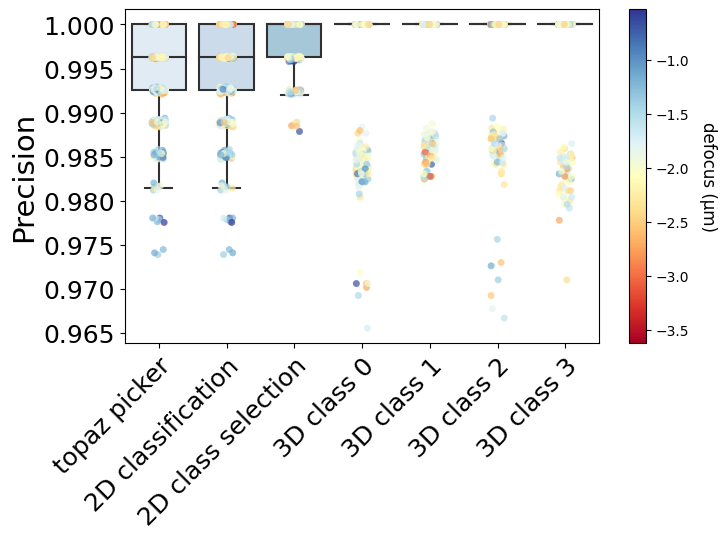

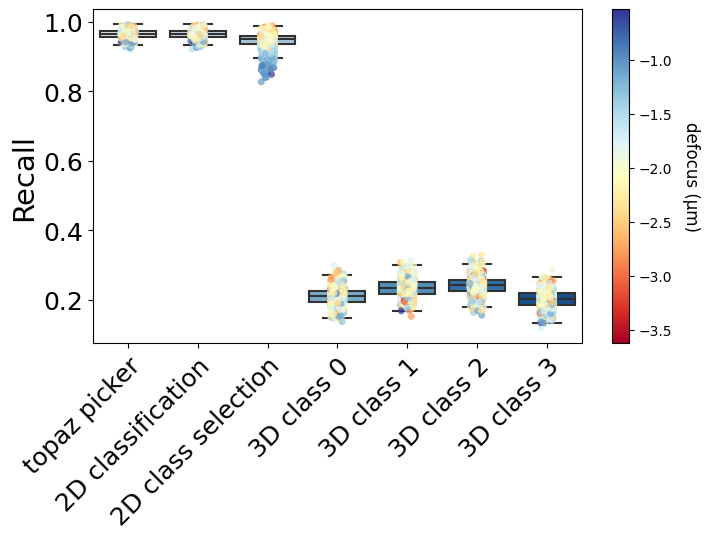

In [4]:
order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])  
fig, ax = plot_precision(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Precision", fontsize=21)

# fig.savefig(os.path.join(figures_dir, "precision.pdf"), bbox_inches="tight")

fig, ax = plot_recall(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Recall", fontsize=21)

# fig.savefig(os.path.join(figures_dir, "recall.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'recall.pdf')}")


In [20]:
# print the precision and recall for the topaz picking job
df_precision["jobtype"] = df_precision["metadata_filename"].apply(lambda x: jobtypes[x])
df_picked["jobtype"] = df_picked["metadata_filename"].apply(lambda x: jobtypes[x])
print(f"unique jobs: {df_precision['jobtype'].unique()}")

print(f"mean precision for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['precision'].mean()}")
print(f"mean recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].mean()}")
print(f"min recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].min()}")
print(f"max recall for topaz picking: {df_precision[df_precision['jobtype'] == 'topaz picker']['recall'].max()}")

print(f"total number of particles for topaz picking job: {len(df_picked[df_picked['jobtype'] == 'topaz picker'])}")
print(f"total number of TP particles picked during topaz picking job: {len(df_picked[(df_picked['jobtype'] == 'topaz picker') & (df_picked['TP'] == 1)])}")
print(f"total number of GT particles in the dataset: {len(df_truth)}")
print(f"fraction of GT particles picked during topaz picking job: {len(df_picked[(df_picked['jobtype'] == 'topaz picker') & (df_picked['TP'] == 1)])/len(df_truth)}")

FN_sum = df_precision[df_precision['jobtype'] == 'topaz picker']['FN'].sum()
print(f"fraction of ground-truth particles that have not been picked: {FN_sum/len(df_truth)}")

df_precision[df_precision['jobtype'] == 'topaz picker'].head(n=1)

unique jobs: ['2D classification' 'topaz picker' '2D class selection' '3D class 0'
 '3D class 1' '3D class 2' '3D class 3']
mean precision for topaz picking: 0.9952781355043352
mean recall for topaz picking: 0.9650504845205384
min recall for topaz picking: 0.9214285714285714
max recall for topaz picking: 0.9927272727272727
total number of particles for topaz picking job: 240974
total number of TP particles picked during topaz picking job: 239831
total number of GT particles in the dataset: 270000
fraction of GT particles picked during topaz picking job: 0.8882629629629629
fraction of ground-truth particles that have not been picked: 0.03221851851851852


metadata_filename ugraph_filename  \
900  /home/mjoosten1/projects/roodmus/data/DE-Shaw_...      000000.mrc   

          defocus  num_particles_picked  num_particles_truth     TP   FP  \
900 -15309.734341                   269                  300  269.0  0.0   

       FN  precision    recall  multiplicity       jobtype  
900  12.0        1.0  0.957295          0.96  topaz picker

In [10]:
def _grab_xy_array(pos):
    """Create a np array to ckdtree for number of neighbours as function
    of distance.

    Args:
        pos (dictview): dict.values() output holding x,y positions.

    Returns:
        np.ndarray: particle centre positions
    """
    particle_centres = np.empty(
        (int(len(pos)) + int(len(pos))), dtype=float
    )
    particle_centres[0::2] = pos[:, 0]
    particle_centres[1::2] = pos[:, 1]
    particle_centres = particle_centres.reshape(
        int(len(particle_centres) / 2), 2
    )
    return particle_centres

from scipy.spatial import cKDTree
def _calc_dist_array(pos_picked, pos_truth, image_shape):
    """Calculates an array of distances between each pair of truth and
    picked particles.

    Args:
        pos_picked (dictview): dict.values() output holding x,y positions
        of picked particles
        pos_truth (dictview): dict.values() output holding x,y positions
        of truth particles
        image_shape (Tuple[int, int]): Pixel dimensions of image
        projection.

    Returns:
        np.ndarray: sparse distance matrix converted to non-sparse array.
    """
    r = 4*np.sqrt(
        np.power(float(image_shape[0]), 2)
        + np.power(float(image_shape[1]), 2)
    )
    truth_centres = _grab_xy_array(pos_truth)
    picked_centres = _grab_xy_array(pos_picked)
    sdm = (
        cKDTree(picked_centres)
        .sparse_distance_matrix(cKDTree(truth_centres), r)
        .toarray()
    )
    # sdm[sdm < np.finfo(float).eps] = np.nan
    return sdm

In [19]:
picked_particles_in_ugraph = df_picked.groupby(["jobtype", "ugraph_filename"]).get_group(("topaz picker", "000000.mrc"))
truth_particles_in_ugraph = df_truth.groupby(["ugraph_filename"]).get_group("000000.mrc")

pos_picked_in_ugraph = picked_particles_in_ugraph[
    ["position_x", "position_y"]
].values
pos_truth_in_ugraph = truth_particles_in_ugraph[
    ["position_x", "position_y"]
].values

sdm = _calc_dist_array(
    pos_picked_in_ugraph, pos_truth_in_ugraph, ugraph_shape
)

sdm.shape
TP: float = (
    0  # the number of true positives in the current micrograph
)
FP: float = (
    0  # the number of false positives in the current micrograph
)
for particle in range(len(pos_picked_in_ugraph)):
    TP += float(np.any(sdm[particle] < particle_diameter / 2))
    FP += float(np.all(sdm[particle] > particle_diameter / 2))

print(f"found TP particles: {TP}")
print(f"found FP particles: {FP}")

FN: float = (
    0.0  # the number of false negatives in the current micrograph
)
for particle in range(len(pos_truth_in_ugraph)):
    FN += float(
        np.all(sdm[:, particle] > particle_diameter / 2)
    )
    print(np.min(sdm[:,particle]))

print(f"found FN particles: {FN}")

found TP particles: 269.0
found FP particles: 0.0
4.798971552155169
11.97446980085493
6.4263320130266495
14.561989113176766
25.714261258547488
41.82262007662389
6.168599599572032
31.294245531127423
13.813531334521663
10.947851745541223
9.353491564457062
4.045953956939423
18.82133906261853
12.72684160737901
26.615160995654342
20.508640800097467
25.11698614643423
3.1292126782121317
9.755599663592964
27.272247782688442
9.767437677378648
57.95044430655827
27.227469901475967
7.500485445246419
4.615264865437129
13.093725045839093
47.010354238858106
14.592479318134716
20.176416029734874
8.534241227262997
11.111324394119503
5.884763676503463
11.371618698574016
21.11097755093845
13.591564382041149
31.68673827146435
4.684436041204114
2.355914730225928
1.0587895061053592
8.802139854625883
15.433328170658891
10.049648388043911
7.5122755563887855
6.467792316854443
16.056721894398866
21.578563883224696
4.4069660565376365
4.5315152309670514
38.72475817542055
7.619129673750223
15.043543798430505
46.95

In [17]:
particle

299

# in text
Compare the local resolution maps for the single-conformation dataset and the conformationally heterogeneous data by masking the LocRes maps and computing the variance in resolution over the map.

In [ ]:
# single-conformation dataset
locres_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/LocalRes/job041/relion_locres.mrc"
mask_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/MaskCreate/job039/mask.mrc"

# conformationally heterogeneous dataset
locres_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/LocalRes/job037/relion_locres.mrc"
mask_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/MaskCreate/job015/mask.mrc"

# load the mrc files
locres_sc = mrcfile.open(locres_sc_file, mode='r')
mask_sc = mrcfile.open(mask_sc_file, mode='r')
locres_sc_data = locres_sc.data * mask_sc.data
locres_sc_data[locres_sc_data == 0] = np.nan
locres_ht = mrcfile.open(locres_ht_file, mode='r')
mask_ht = mrcfile.open(mask_ht_file, mode='r')
locres_ht_data = locres_ht.data * mask_ht.data
locres_ht_data[locres_ht_data == 0] = np.nan

# plot the local resolution
fig, ax = plt.subplots(1, 2, figsize=(4.5*2, 4.5))
ax[0].hist(locres_sc_data.flatten(), bins=100, range=(0, 10), density=True, color="blue", alpha=0.5);
ax[0].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[0].set_ylabel("Density", fontsize=21)
ax[0].set_title("Single conformation", fontsize=21)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].hist(locres_ht_data.flatten(), bins=100, range=(0, 10), density=True, color="orange", alpha=0.5);
ax[1].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[1].set_ylabel("Density", fontsize=21)
ax[1].set_title("Conformationally heterogeneous", fontsize=21)
ax[1].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

# print the mean and variance of the local resolution
print(f"mean single conformation: {np.nanmean(locres_sc_data)}")
print(f"mean conformationally heterogeneous: {np.nanmean(locres_ht_data)}")
print(f"variance single conformation: {np.nanvar(locres_sc_data)}")
print(f"variance conformationally heterogeneous: {np.nanvar(locres_ht_data)}")
print(f"min single conformation: {np.nanmin(locres_sc_data)}")
print(f"min conformationally heterogeneous: {np.nanmin(locres_ht_data)}")
print(f"max single conformation: {np.nanmax(locres_sc_data)}")
print(f"max conformationally heterogeneous: {np.nanmax(locres_ht_data)}")
